In [1]:
%matplotlib notebook

In [2]:
import pyspark
sc = pyspark.sql.SparkSession.Builder().getOrCreate()

In [3]:
import json
import numpy as np
import pandas as pd
import seaborn as sn

import matplotlib.pyplot as plt
from IPython.display import display, HTML
import math
import time
import matplotlib.animation as animation
from datetime import datetime, timedelta
import pyspark.sql.functions as F

from utils.emissions_normalizer import EmissionsNormalizer
from utils.knn_predictor import KnnPredictor
from utils.smoother import Smoother
from utils.random_predictor import RandomPredictor

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [4]:
ANTENNAS_POSITION = [(464259.981343845,6110331.85100085),(463512.015195402,6111004.324434620),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
ANTENNAS_NAMES = ["RC1", "RC2", "D1", "D2"] 
X_0 = 462385.503783397
Y_0 = 6109042.35153865

for i in range(4):
    ANTENNAS_POSITION[i] = (ANTENNAS_POSITION[i][0]-X_0, ANTENNAS_POSITION[i][1]-Y_0)

GRID = Polygon(ANTENNAS_POSITION)

In [5]:
#GRID = Polygon([(1750,1600), (1750,2000), (2200, 2000), (2200, 1600)])
#GRID = Polygon([(1450,1800),(1450,2000),(2200,2000),(2200,1800)])



FEMALES = [11, 15, 17, 20, 24, 26, 28, 30, 33, 34]
MALES = [10, 14, 16, 21, 22, 23, 25, 27, 29, 31, 32]

## Entreno el modelo que vamos a usar para predecir

In [6]:
points_recep = sc.read.json('datos/train-test-by-emission.jsonlines/').rdd

In [7]:
normalizer = EmissionsNormalizer()
data = normalizer.normalize(points_recep)
regre_data, regre_target = normalizer.get_regression_dataframes(data)

In [8]:
predictor = KnnPredictor()
predictor.fit(regre_data, regre_target)

In [9]:
random_predictor = RandomPredictor()
random_predictor.fit(regre_data, regre_target)

## Levanto el archivo con las emisiones de los pajaros

In [10]:
birds_recep = sc.read.json('datos/all-birds-data.jsonlines/').rdd
birds_recep = birds_recep.sortBy(lambda x: x['timestamp'])

### Me quedo solo con pajaros etiquetados

In [11]:
birds_recep = birds_recep.filter(lambda x: x['tag_id'] in MALES+FEMALES)

### Obtengo cual es el dia inicial en el que todos los pajaros tienen chip

In [12]:
birds_recep_df = birds_recep.toDF()
birds_start_date = birds_recep_df.groupBy('tag_id').agg(F.min("timestamp"))
birds_start_date.agg(F.max('min(timestamp)')).collect()

[Row(max(min(timestamp))='2018-01-02 21:13:07')]

In [13]:
#start_date = '2018-01-03'
start_date = '2018-01-10' ## Fecha que me pasó Romina

### Obtengo cual es el dia final en el que todos los pajaros tienen chip

In [14]:
birds_end_date = birds_recep_df.groupBy('tag_id').agg(F.max("timestamp"))
birds_end_date.agg(F.min('max(timestamp)')).collect()

[Row(min(max(timestamp))='2018-01-26 15:27:50')]

In [15]:
end_date = '2018-01-26'
#end_date = '2018-02-08'

### Filtro a partir de las fechas obtenida

In [16]:
birds_recep = birds_recep.filter(lambda x: x['timestamp'] >= start_date and  x['timestamp'] < end_date)

In [17]:
birds_recep.count()

1069514

### Filtro en solo los horarios que nos interesa analizar y hago un checkpoint en disco

In [ ]:
START_TIME = '08:00:00'
END_TIME = '19:00:00'
birds_data_complete_df = birds_recep.filter(lambda x: START_TIME <= x['timestamp'].split(' ')[1] < END_TIME).toDF()
birds_data_complete_df.write.parquet('tmp/checkpoint-cog.parquet')



### Levanto el chekpoint en pandas

In [9]:
birds_data_complete = pd.read_parquet('tmp/checkpoint-cog.parquet')
birds_data = birds_data_complete.drop(columns=['tag_id','timestamp'])

### Obtengo las predicciones

In [10]:
predictions = predictor.predict(birds_data)
predictions = pd.concat([pd.DataFrame(predictions), pd.DataFrame(birds_data_complete)], axis=1).values

In [11]:
pd.DataFrame(predictions)

0        1   2   3   4    5   6                    7
0       1900.38   1263.6   0  85   0    0  29  2018-01-10 08:00:00
1       2508.09  2186.93   0   0   0  179  21  2018-01-10 08:00:01
2       2106.02  2033.84  28   0   0  115  33  2018-01-10 08:00:02
3        1872.8  2141.22  30   0  71   69  32  2018-01-10 08:00:02
4       2363.64  1077.55   0  17   0    0  27  2018-01-10 08:00:03
5       1014.26  1800.45  36   0   0    0  14  2018-01-10 08:00:03
6       2616.93  1815.03   0   0   0  192  20  2018-01-10 08:00:04
7       1985.74   1315.4   0  80   0    0  29  2018-01-10 08:00:05
8        2787.6   1918.6   0   0   0  180  21  2018-01-10 08:00:06
9       2272.38  1536.01   0  35   0    0  24  2018-01-10 08:00:06
10      2104.72  1504.37   0  34   0    0  27  2018-01-10 08:00:07
11      2259.13  1874.36  35   0   0  106  33  2018-01-10 08:00:07
12      2156.95  1921.09  32   0   0   58  32  2018-01-10 08:00:07
13      1462.89  1792.33  42   0   0    0  14  2018-01-10 08:00:08
14      2104.75   1504.4   0  89   0    0  29  2018-01-10 08:00:09
15      2616.93  1815.03   0   0   0  192  20  2018-01-10 08:00:09
16      2543.83  2050.99   0   0   0  177  21  2018-01-10 08:00:11
17      2071.13  1367.19   0  88   0    0  34  2018-01-10 08:00:11
18      2311.85  1162.85   0  23   0    0  27  2018-01-10 08:00:12
19      2822.65  1764.69   0   0   0   90  33  2018-01-10 08:00:12
20      2767.01  1760.12   0   0   0   59  32  2018-01-10 08:00:12
21      1014.26  1800.45  36   0   0    0  14  2018-01-10 08:00:14
22      2616.93  1815.03   0   0   0  192  20  2018-01-10 08:00:14
23      2438.64  1790.91  34   0   0  101  33  2018-01-10 08:00:15
24      2010.15   1236.8   0  77   0    0  29  2018-01-10 08:00:15
25       2037.7  2070.76  37   0   0   56  32  2018-01-10 08:00:15
26      2615.48  2106.13   0   0   0  182  21  2018-01-10 08:00:16
27      1462.89  1792.33  42   0   0    0  14  2018-01-10 08:00:19
28      2709.96  2046.64   0   0   0  190  20  2018-01-10 08:00:19
29      1985.74   1315.4   0  80   0    0  29  2018-01-10 08:00:20
...         ...      ...  ..  ..  ..  ...  ..                  ...
340466  1505.16   2261.7  63   0   0    0  30  2018-01-25 18:58:25
340467  1264.76   1695.5  41   0   0    0  26  2018-01-25 18:58:25
340468  1342.82  1836.27  44   0   0    0  22  2018-01-25 18:58:27
340469  947.865  2063.79  45   0   0    0  25  2018-01-25 18:58:27
340470  1773.83  1934.26  59   0   0    0  30  2018-01-25 18:58:29
340471  1405.78   2271.5  49   0   0    0  26  2018-01-25 18:58:30
340472  1113.63  1790.66  38   0   0    0  30  2018-01-25 18:58:35
340473  2333.31  1448.38   0  27   0    0  32  2018-01-25 18:58:40
340474  1819.88  1973.86  17   0   0    0  26  2018-01-25 18:58:41
340475  2291.15  1197.04   0  41   0    0  24  2018-01-25 18:58:48
340476  1344.82  2141.07  32   0   0    0  26  2018-01-25 18:58:51
340477  1408.63  1689.35  37   0   0    0  26  2018-01-25 18:58:56
340478  2263.14  1320.19   0  38   0    0  24  2018-01-25 18:59:03
340479  1344.82  2141.07  32   0   0    0  26  2018-01-25 18:59:05
340480  2291.15  1197.04   0  41   0    0  24  2018-01-25 18:59:07
340481  1771.09  1091.75   0  33   0    0  24  2018-01-25 18:59:12
340482  1264.76   1695.5  41   0   0    0  27  2018-01-25 18:59:17
340483  2104.72  1504.37   0  34   0    0  24  2018-01-25 18:59:18
340484  1345.33  2024.63  39   0   0    0  26  2018-01-25 18:59:25
340485     1513  2056.27  56   0   0    0  27  2018-01-25 18:59:26
340486  1238.73  2123.44  35   0   0    0  26  2018-01-25 18:59:31
340487     1574  2186.69  51   0   0    0  27  2018-01-25 18:59:32
340488  1217.97  2157.57  54   0   0    0  27  2018-01-25 18:59:37
340489  1451.99  1925.83  55   0   0    0  27  2018-01-25 18:59:41
340490  2272.38  1536.01   0  35   0    0  32  2018-01-25 18:59:41
340491  1517.77  1778.91  18   0   0    0  30  2018-01-25 18:59:44
340492  1526.42  2111.11  53   0   0    0  27  2018-01-25 18:59:47
340493  1474.08  2312.92  47   0   0    0  27  2018-01-25 18:

### Aplico un suavizado a las predicciones

In [12]:
smoother = Smoother()
smooth_predictions = smoother.smooth_predictions(predictions)

### Aplico un filtro por suavizado a la predicciones

In [ ]:
smooth_filter_predictions = smoother.filter_predictions(predictions)

### Obtengo predicciones random

In [13]:
random_predictions = random_predictor.predict(birds_data)
random_predictions = pd.concat([pd.DataFrame(random_predictions), pd.DataFrame(birds_data_complete)], axis=1).values

### Calculo si la prediccion cayó dentro de la grilla

In [12]:
def set_prediction_grid_classification(predictions):
    grid_predictions = []
    for i in range(len(predictions)):
        prediction = predictions[i]
        point = Point(prediction[0], prediction[1])
        if GRID.contains(point):
            grid_pred = np.insert(prediction, 8,'in_grid', axis=0)
        else:
            grid_pred = np.insert(prediction, 8,'out_grid', axis=0)
        grid_predictions.append(grid_pred)
    return pd.DataFrame(grid_predictions, columns=['x', 'y', 'recep_0', 'recep_1', 'recep_2', 'recep_3', 'tag', 'time', 'region'])


### Obtengo el tiempo en que cada posible pareja esta junta

In [13]:
def get_bird_timestamp_in_grid(bird_data, delta_time_in_sec):
    """
    delta_time_in_sec es la cantidad de segundos que decimos que el pajaro se encuentra en un mismo punto dada una prediccion
    Por default, el valor es 5, ya que las emisiones son cada 5 segundos.
    """
    timestamp_in_grid = []
    for row in bird_data['time']:
        real_time = datetime.strptime(row, '%Y-%m-%d %H:%M:%S')
        for i in range(-delta_time_in_sec, delta_time_in_sec+1):
            res=real_time+timedelta(seconds=i)
            timestamp_in_grid.append(datetime.strftime(res, '%Y-%m-%d %H:%M:%S'))

    timestamp_in_grid = list(set(timestamp_in_grid))
    return pd.DataFrame(timestamp_in_grid, columns=['time'])


def get_grid_matches_per_bird(grid_predictions, delta_time):
    male_birds_in_grid = grid_predictions[(grid_predictions.tag.isin(MALES)) & (grid_predictions['region'] == 'in_grid')]

    matches_per_bird = {}
    for female_bird in FEMALES:
        female_bird_in_grid = grid_predictions[(grid_predictions['tag'] == female_bird) & (grid_predictions['region'] == 'in_grid')]
        timestamp_in_grid_pd = get_bird_timestamp_in_grid(female_bird_in_grid, delta_time)

        male_in_grid_with_female = male_birds_in_grid.join(timestamp_in_grid_pd.set_index('time'), on='time', how='inner')

        female_matches = {}
        for index, row in male_in_grid_with_female.iterrows():
            tag = row['tag']
            current_matches = female_matches.get(tag, 0)
            female_matches[tag] = current_matches+1

        matches_per_bird[female_bird] = female_matches
    return matches_per_bird



### Imprimo matriz de confusion

In [14]:
def show_confusion_matrices(matches_per_female):
    matrix_res = [[]] * len(FEMALES)
    for i in range(len(FEMALES)):
        matrix_res[i] = []
        for m in MALES:
            matrix_res[i].append(matches_per_female.get(FEMALES[i]).get(m, 0))
         
    plt.figure(figsize=(10,15))
    
    plt.subplot(3, 1, 1)
    plt.title('Birds matches')
    matrix_res_pd = pd.DataFrame(matrix_res)
    matrix_res_pd.columns = MALES
    matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
    ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0)
    ax.set(xlabel='Males', ylabel='Females')



    ### Esto muestra, para cada hembra, que porcentaje del tiempo que los otros machos estuvieron en la grilla 
    ### con cualquier hembra estuvieron juntos
    plt.subplot(3, 1, 2)
    plt.title('Male time distribution')
    matrix_res_pd = pd.DataFrame(matrix_res)
    matrix_res_pd.columns = MALES
    matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
    matrix_res_pd = (matrix_res_pd/matrix_res_pd.sum()*100).round(2)
    matrix_res_pd = matrix_res_pd.fillna(0)
    ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0, vmax=100)
    ax.set(xlabel='Males', ylabel='Females')


    ### Igual, pero con las hembras
    plt.subplot(3, 1, 3)
    plt.title('Female time distribution')
    matrix_res_pd = pd.DataFrame(matrix_res)
    matrix_res_pd.columns = MALES
    matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
    matrix_res_pd = (matrix_res_pd.div(matrix_res_pd.sum(axis=1), axis=0)*100).round(2)
    matrix_res_pd = matrix_res_pd.fillna(0)
    ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0, vmax=100)
    ax.set(xlabel='Males', ylabel='Females')



In [15]:
def evaluate_grid_coocurrence(predictions, delta_time=5):
    predictions = set_prediction_grid_classification(predictions)
    matches_per_bird = get_grid_matches_per_bird(predictions, delta_time)
    show_confusion_matrices(matches_per_bird)

<IPython.core.display.Javascript object>


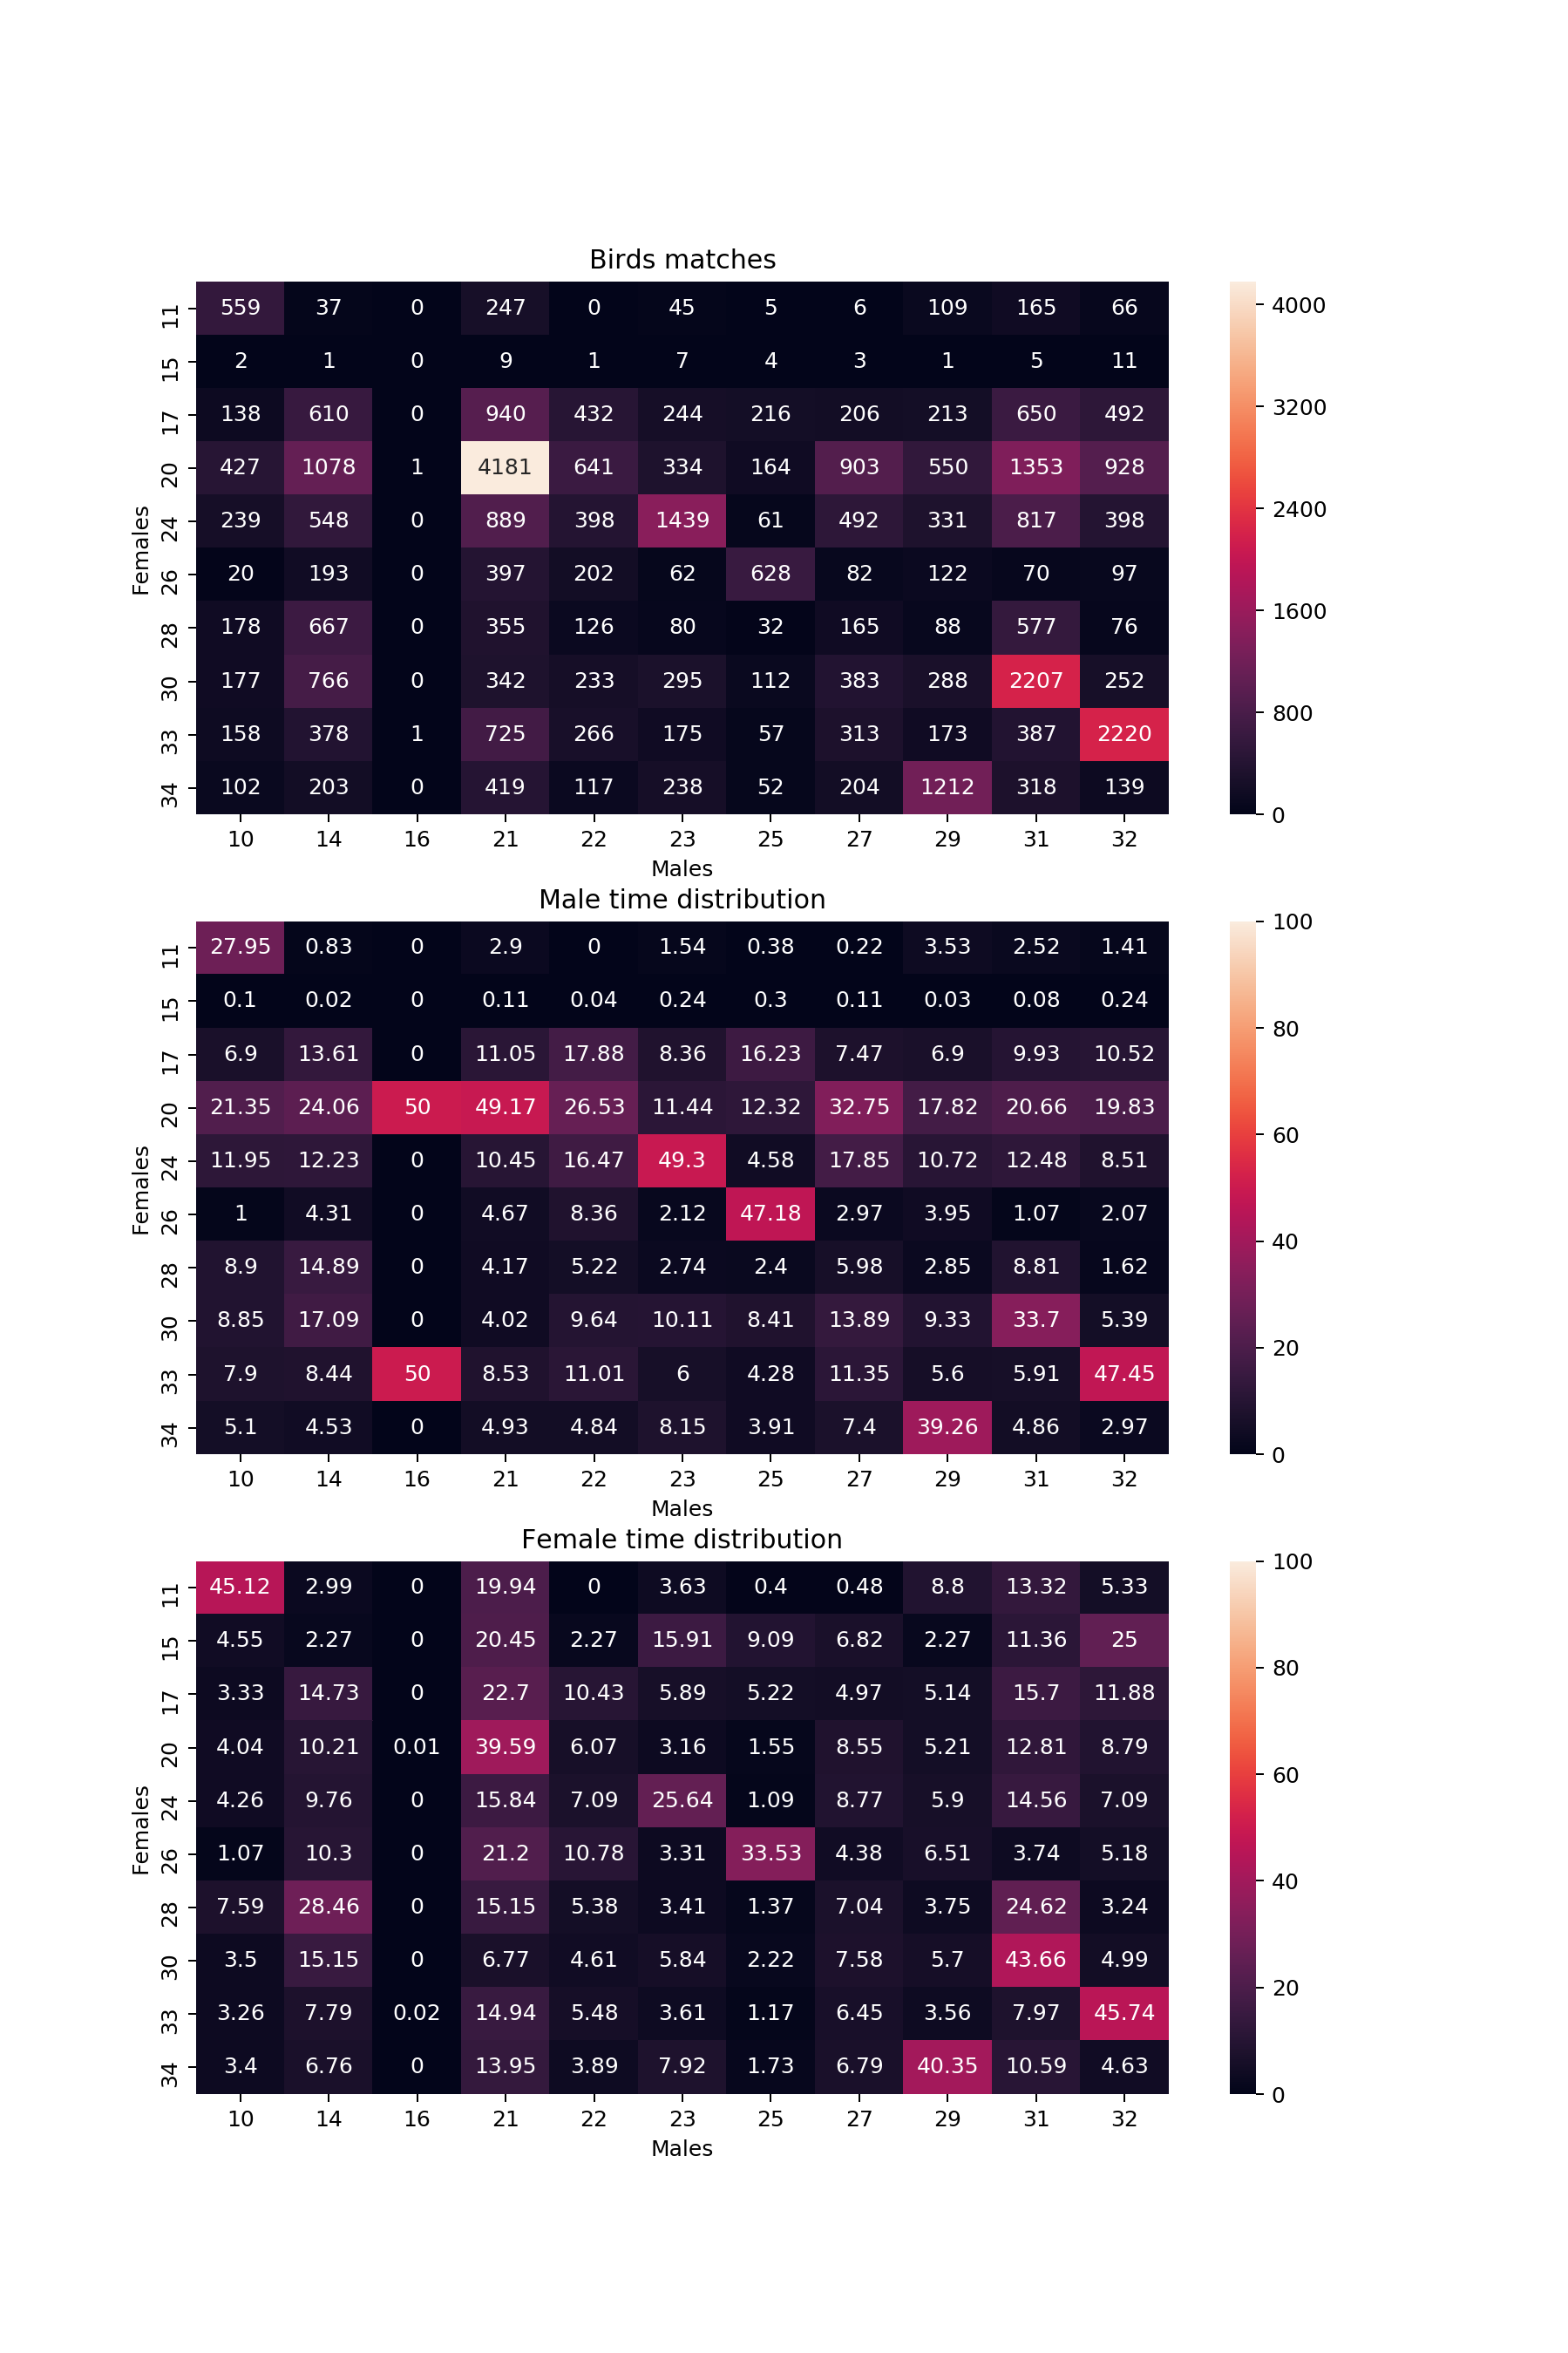

In [16]:
evaluate_grid_coocurrence(predictions)

<IPython.core.display.Javascript object>


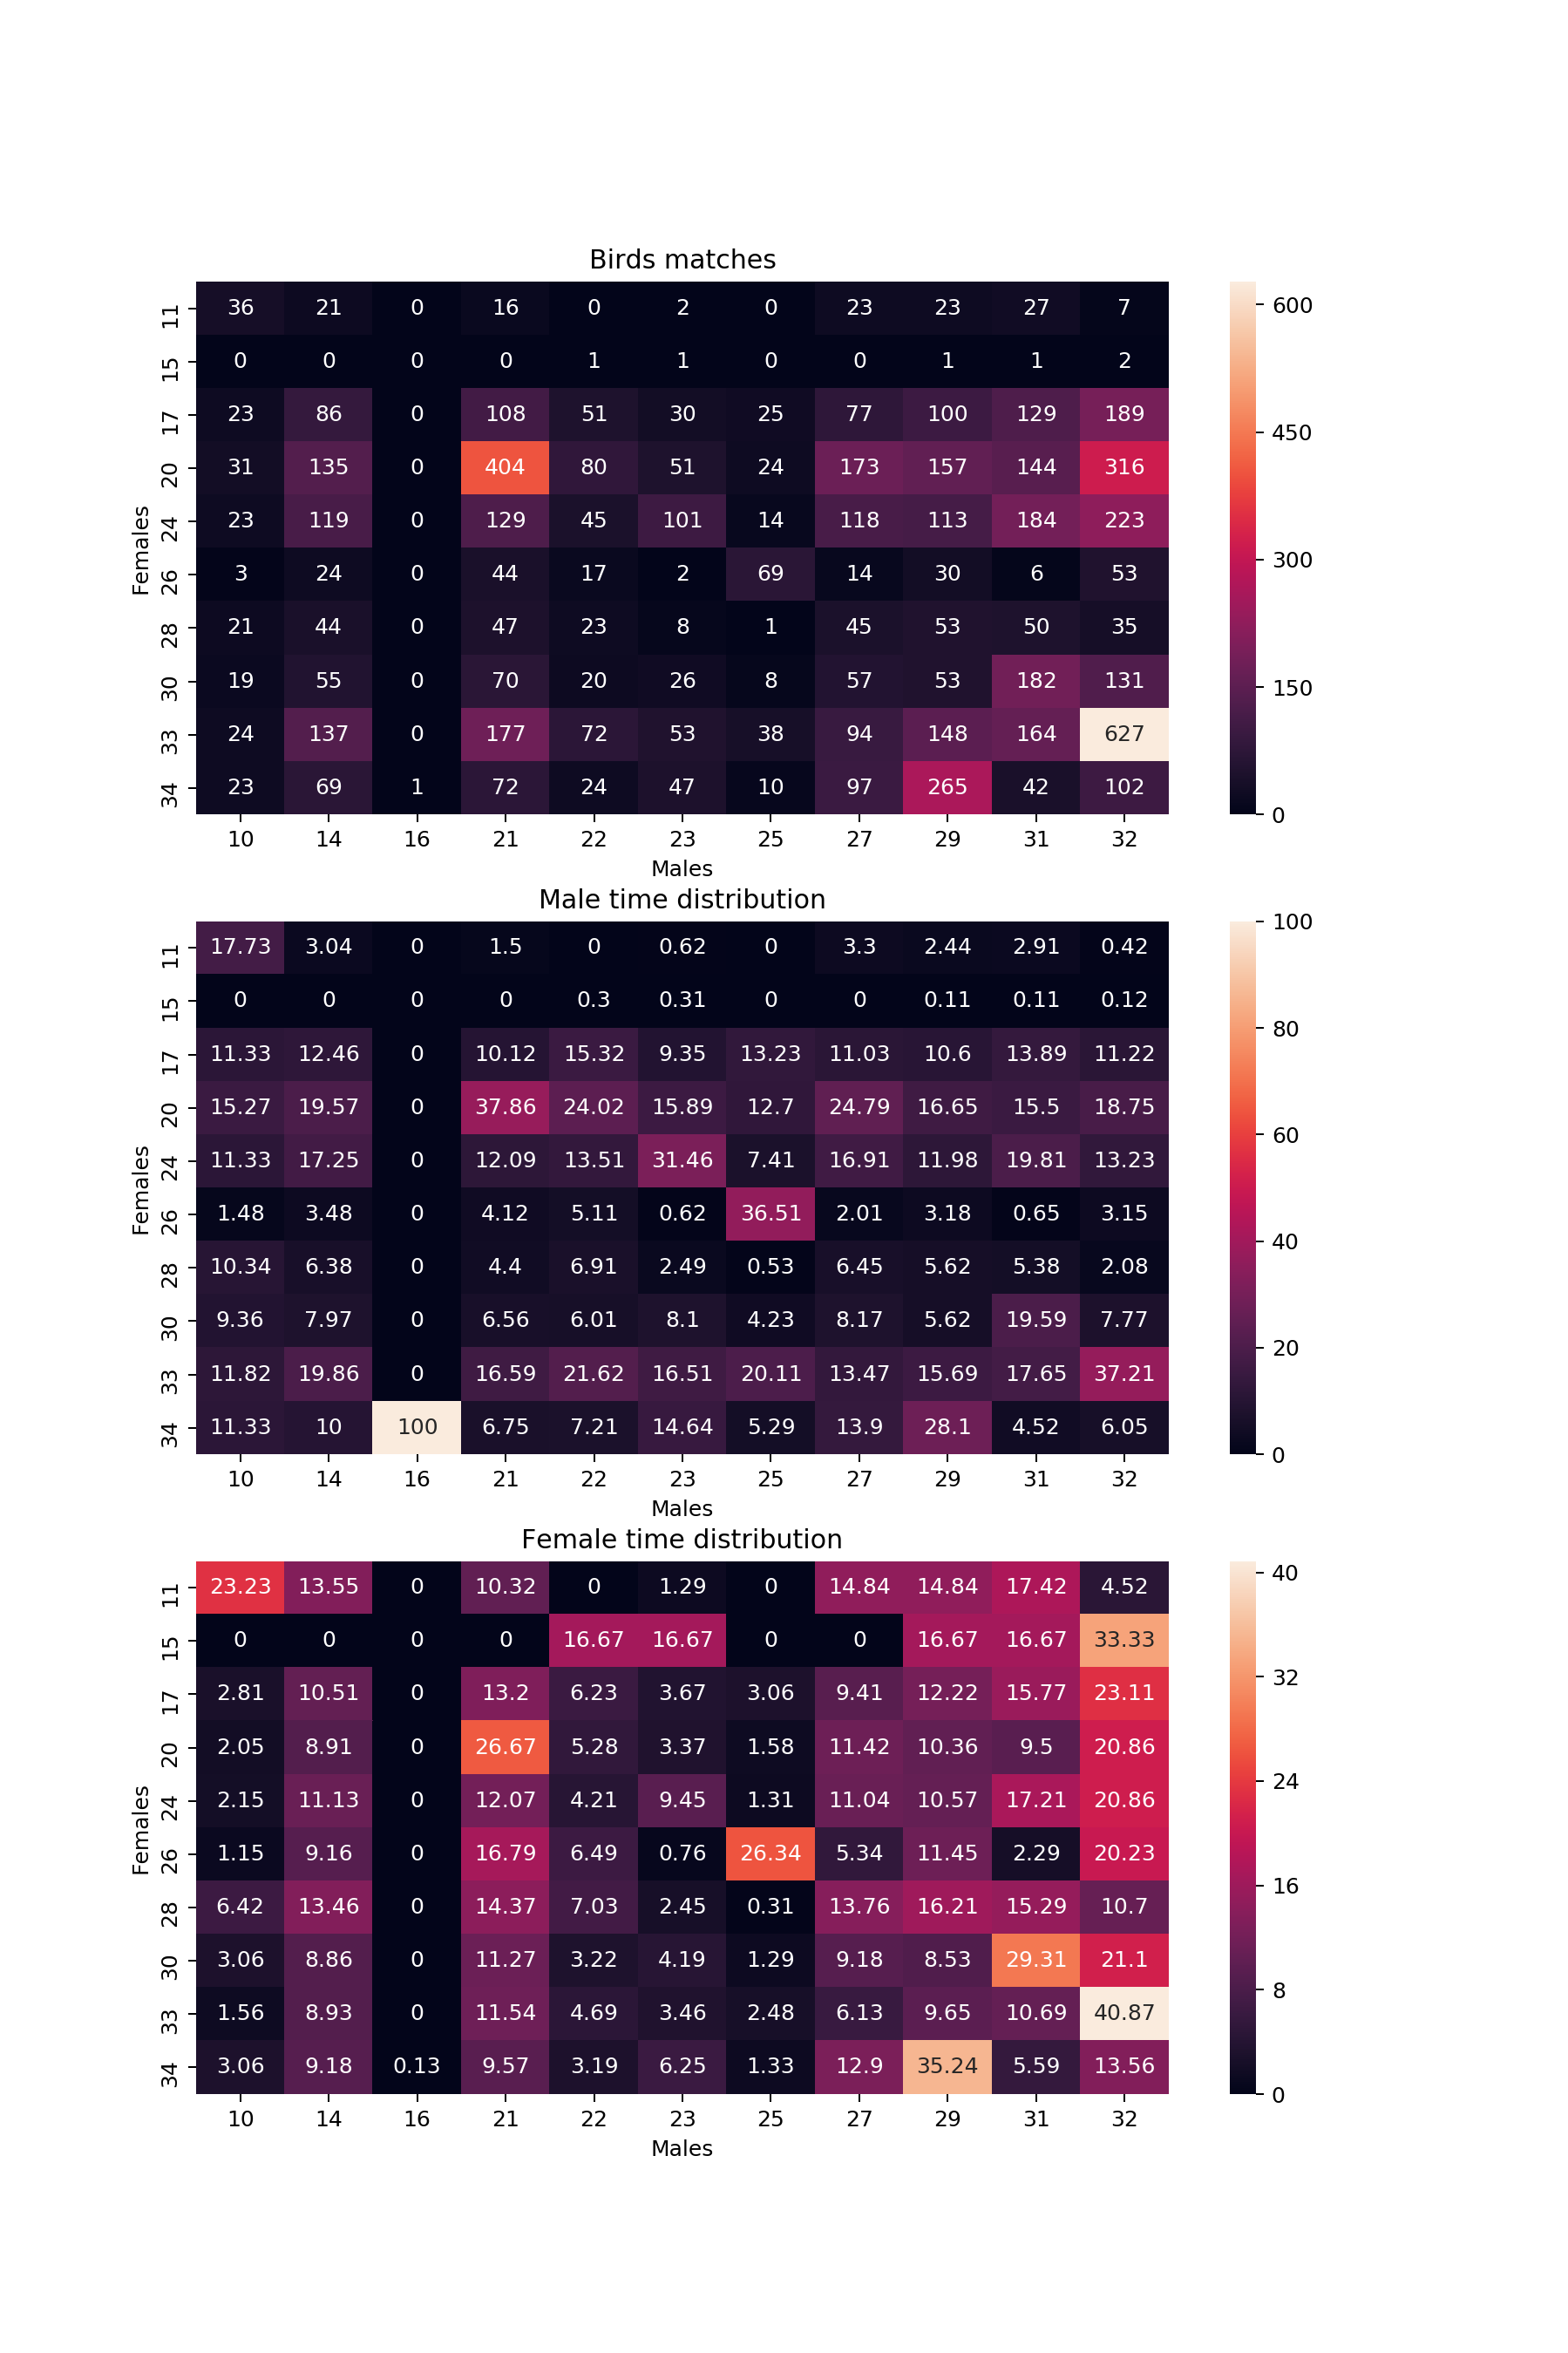

In [62]:
evaluate_grid_coocurrence(random_predictions)

<IPython.core.display.Javascript object>


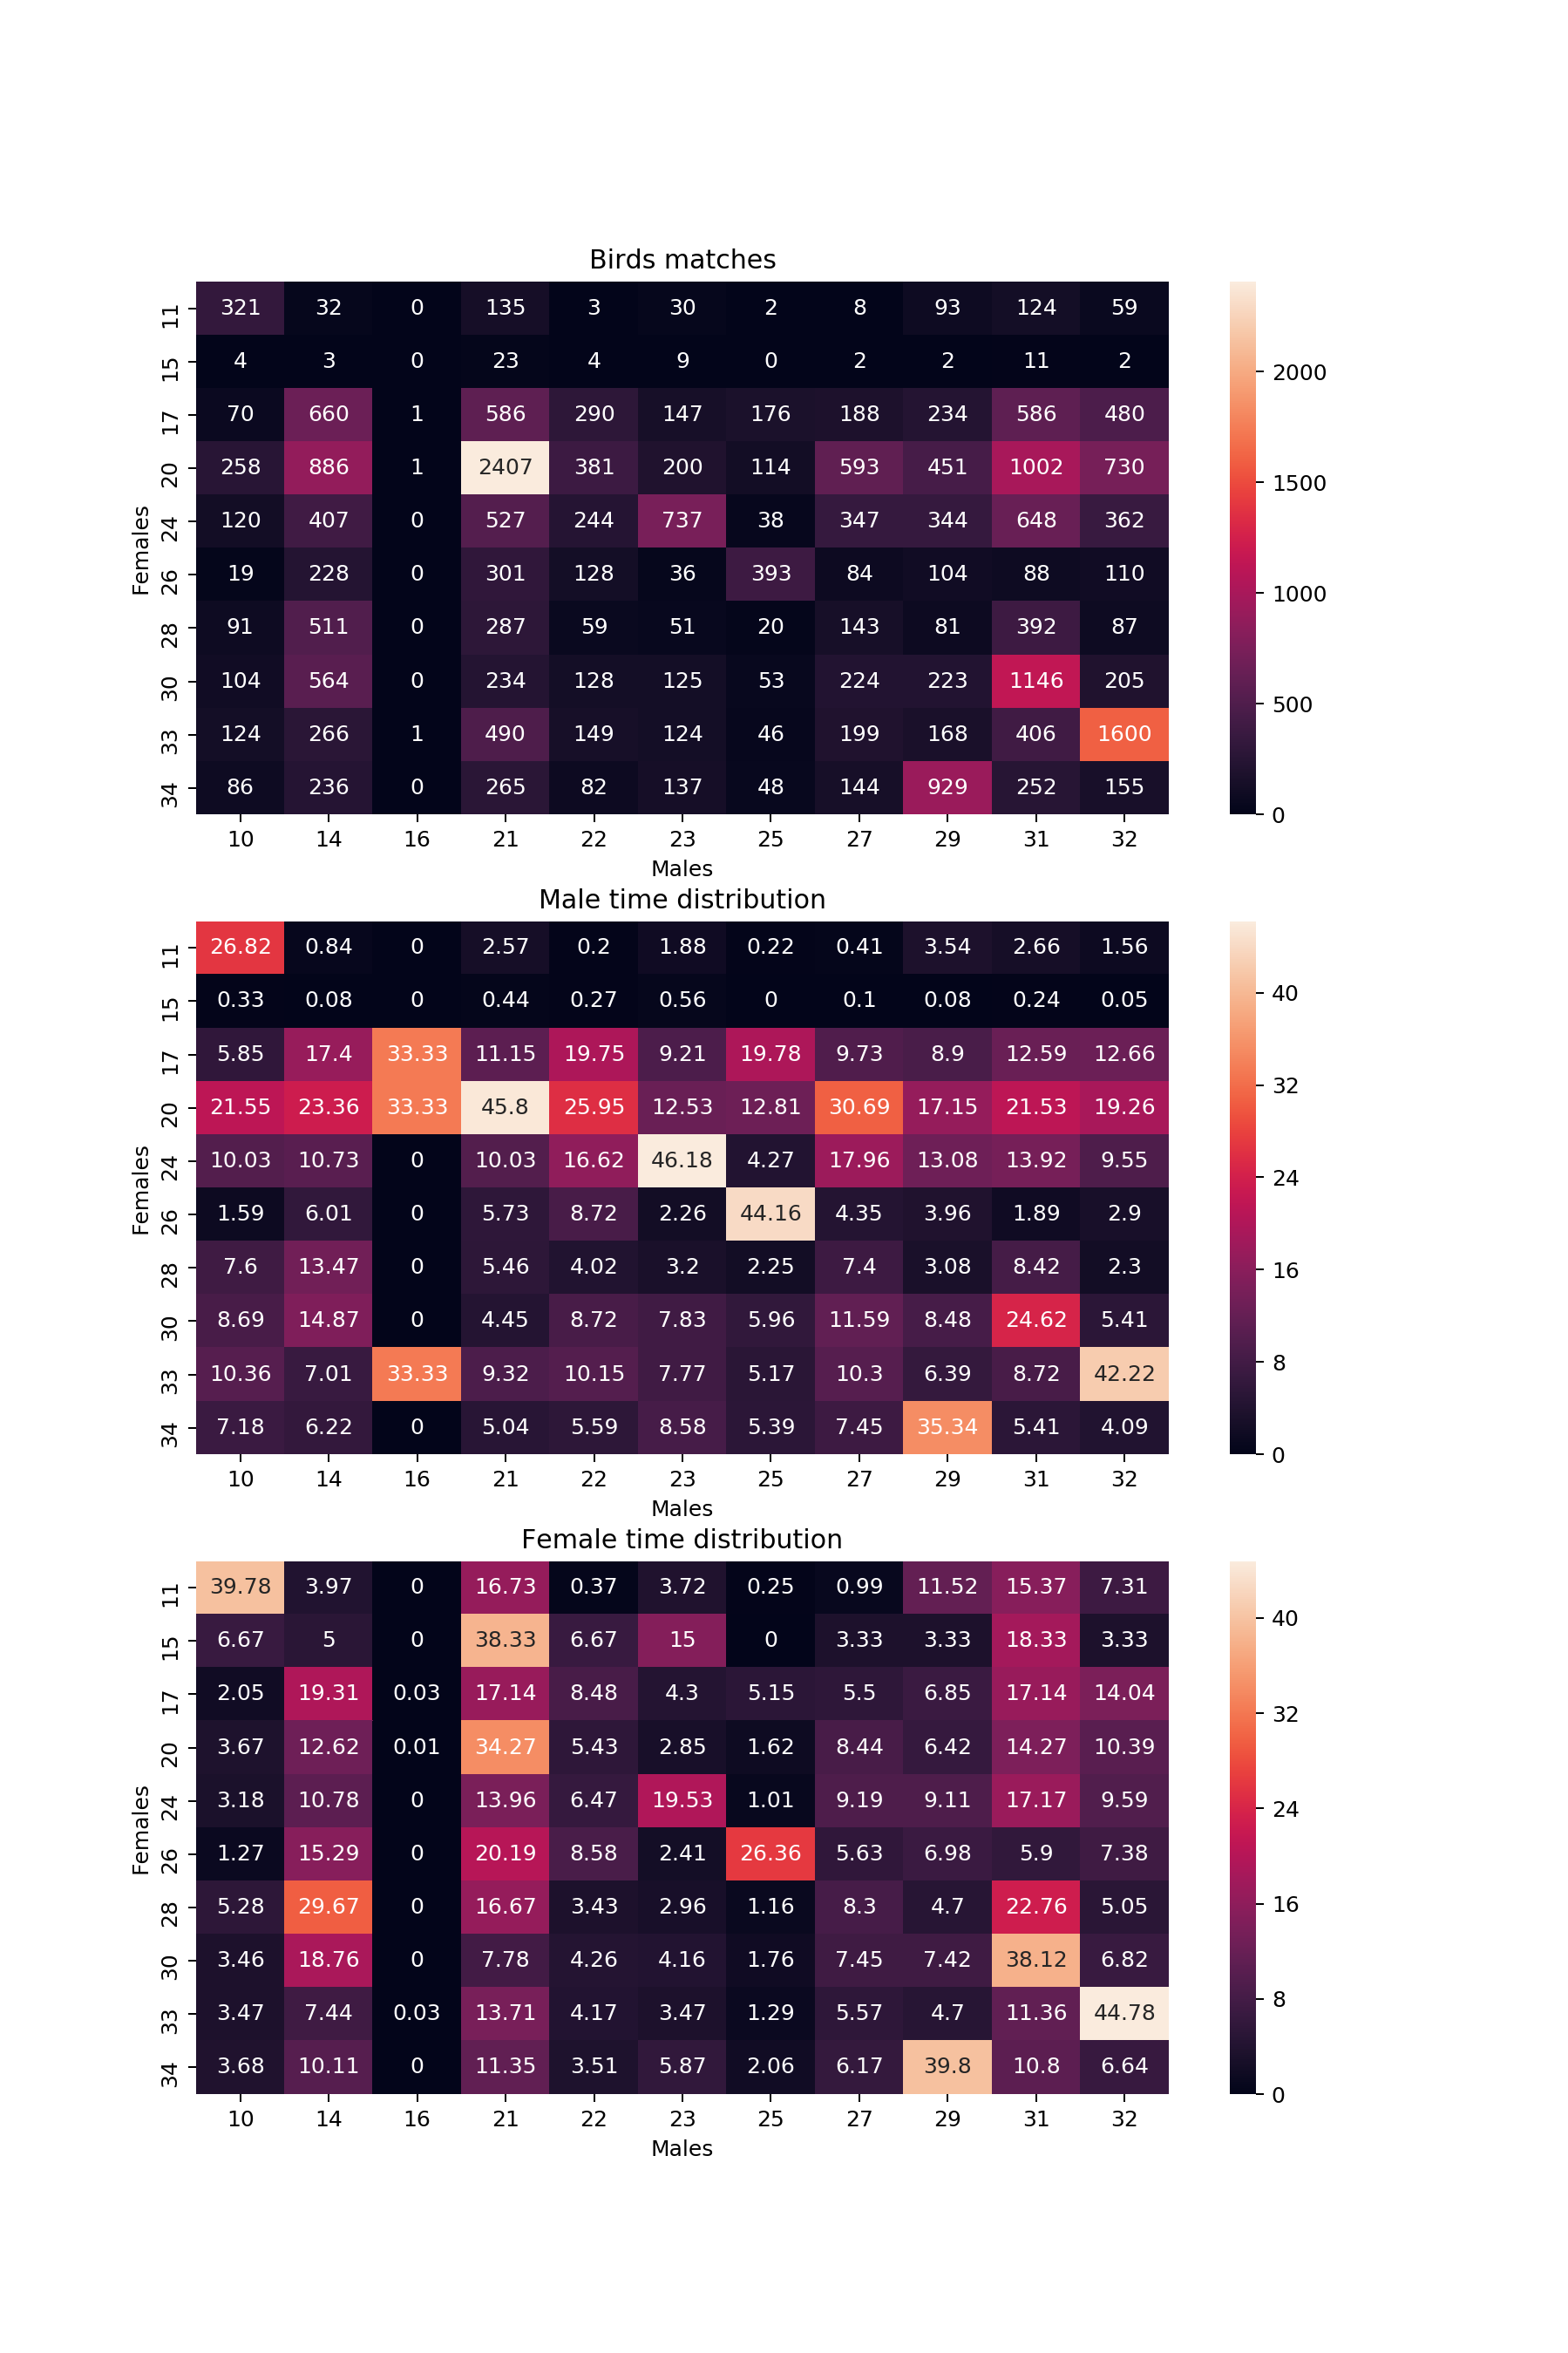

In [60]:
evaluate_grid_coocurrence(smooth_predictions, 5+smoother.step_size)

In [ ]:
####

In [68]:
def get_female_distribution_matrix(matrix_res):
    matrix_res_pd = pd.DataFrame(matrix_res)
    matrix_res_pd = (matrix_res_pd/matrix_res_pd.sum()*100).round(2)
    matrix_res_pd = matrix_res_pd.fillna(0)
    return matrix_res_pd.values

In [69]:

def get_male_distribution_matrix(matrix_res):
    matrix_res_pd = pd.DataFrame(matrix_res)
    matrix_res_pd = (matrix_res_pd.div(matrix_res_pd.sum(axis=1), axis=0)*100).round(2)
    matrix_res_pd = matrix_res_pd.fillna(0)
    return matrix_res_pd.values

In [70]:
def get_best_match_index(matrix_np):
    female_distribution_matrix = get_female_distribution_matrix(matrix_np)
    male_distribution_matrix = get_male_distribution_matrix(matrix_np)
    max_value = matrix_np.max()
    max_index = np.where(matrix_np == max_value)
    
    return max_index

def get_partners(matches_per_female):
    matrix_res = [[]] * len(FEMALES)
    for i in range(len(FEMALES)):
        matrix_res[i] = []
        for m in MALES:
            matrix_res[i].append(matches_per_female.get(FEMALES[i]).get(m, 0))

    partners = []
    matrix_np = np.array(matrix_res)
    
    h = len(matrix_np)
    w = len(matrix_np[0])
    while True:
        max_value = matrix_np.max()
        if max_value <= 0: ## Condiciones de corte. Cuando queremos decir que no tenemos suficientes datos para decir que son pareja
            break

        max_index = get_best_match_index(matrix_np)
        partners.append(max_index)


        matrix_np[:, max_index[1][0]] = np.zeros(h)
        matrix_np[max_index[0][0], :] = np.zeros(w)
    res = []
    for p in partners:
        res.append((FEMALES[p[0][0]], MALES[p[1][0]]))
    return res
    

In [132]:
get_partners(matches_per_bird)

[(20, 21),
 (33, 32),
 (30, 31),
 (24, 23),
 (34, 29),
 (28, 14),
 (26, 25),
 (11, 10),
 (17, 22),
 (15, 27)]

In [75]:
def get_partners_by_grid(predictions, delta_time=5):
    predictions = set_prediction_grid_classification(predictions)
    matches_per_bird = get_grid_matches_per_bird(predictions, delta_time)
    return get_partners(matches_per_bird)

In [76]:
get_partners_by_grid(predictions)

[(20, 21),
 (33, 32),
 (30, 31),
 (24, 23),
 (34, 29),
 (28, 14),
 (26, 25),
 (11, 10),
 (17, 22),
 (15, 27)]

In [ ]:
####

## Analizo coocurrencia en areas cercanas a las antenas

### Calculo si la prediccion fue cercana a alguna antena

In [23]:
MAX_DISTANCE_TO_ANTENNA = 200

antennas = []
for i in range(4):
    antennas.append({
        'pos': Point(ANTENNAS_POSITION[i]),
        'name': ANTENNAS_NAMES[i]
    })

    
def set_prediction_near_antennas_classification(predictions):
    grid_predictions = []
    for i in range(len(predictions)):
        prediction = predictions[i]
        point = Point(prediction[0], prediction[1])

        close_to = None
        for antenna in antennas:
            if antenna['pos'].distance(point) < MAX_DISTANCE_TO_ANTENNA:
                close_to = antenna['name']

        grid_pred = np.insert(prediction, 8,close_to, axis=0)
        grid_predictions.append(grid_pred)
    return pd.DataFrame(grid_predictions, columns=['x', 'y', 'recep_0', 'recep_1', 'recep_2', 'recep_3', 'tag', 'time', 'close_to'])


### Obtengo el tiempo que cada posible pareja estuvo junta

In [24]:
def get_bird_timestamp_near_antennas(bird_data, delta_time_in_sec):
    """
    delta_time_in_sec es la cantidad de segundos que decimos que el pajaro se encuentra en un mismo punto dada una prediccion
    Por default, el valor es 5, ya que las emisiones son cada 5 segundos.
    """
    timestamp_in_grid = []
    for row in zip(bird_data.time, bird_data.close_to):
        real_time = datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S')
        for i in range(-delta_time_in_sec, delta_time_in_sec+1):
            res=real_time+timedelta(seconds=i)
            timestamp_in_grid.append((row[1], datetime.strftime(res, '%Y-%m-%d %H:%M:%S')))

    timestamp_in_grid = list(set(timestamp_in_grid))
    return pd.DataFrame(timestamp_in_grid, columns=['close_to','time'])


def get_matches_per_bird_near_antennas(grid_predictions, delta_time):
    male_birds_in_grid = grid_predictions[(grid_predictions.tag.isin(MALES)) & (grid_predictions.close_to.notnull())]

    matches_per_bird_near_antenna = {}
    for female_bird in FEMALES:
        female_bird_in_grid = grid_predictions[(grid_predictions['tag'] == female_bird) & (grid_predictions.close_to.notnull())]
        timestamp_in_grid_pd = get_bird_timestamp_near_antennas(female_bird_in_grid, delta_time)

        male_in_grid_with_female = male_birds_in_grid.join(timestamp_in_grid_pd.set_index(['close_to','time']), on=['close_to','time'], how='inner')

        female_matches = {}
        for index, row in male_in_grid_with_female.iterrows():
            tag = row['tag']
            current_matches = female_matches.get(tag, 0)
            female_matches[tag] = current_matches+1

        matches_per_bird_near_antenna[female_bird] = female_matches
    return matches_per_bird_near_antenna



In [21]:
def evaluate_near_antenna_coocurrence(predictions, delta_time=5):
    predictions = set_prediction_near_antennas_classification(predictions)
    matches_per_bird = get_matches_per_bird_near_antennas(predictions, delta_time)
    show_confusion_matrices(matches_per_bird)

<IPython.core.display.Javascript object>


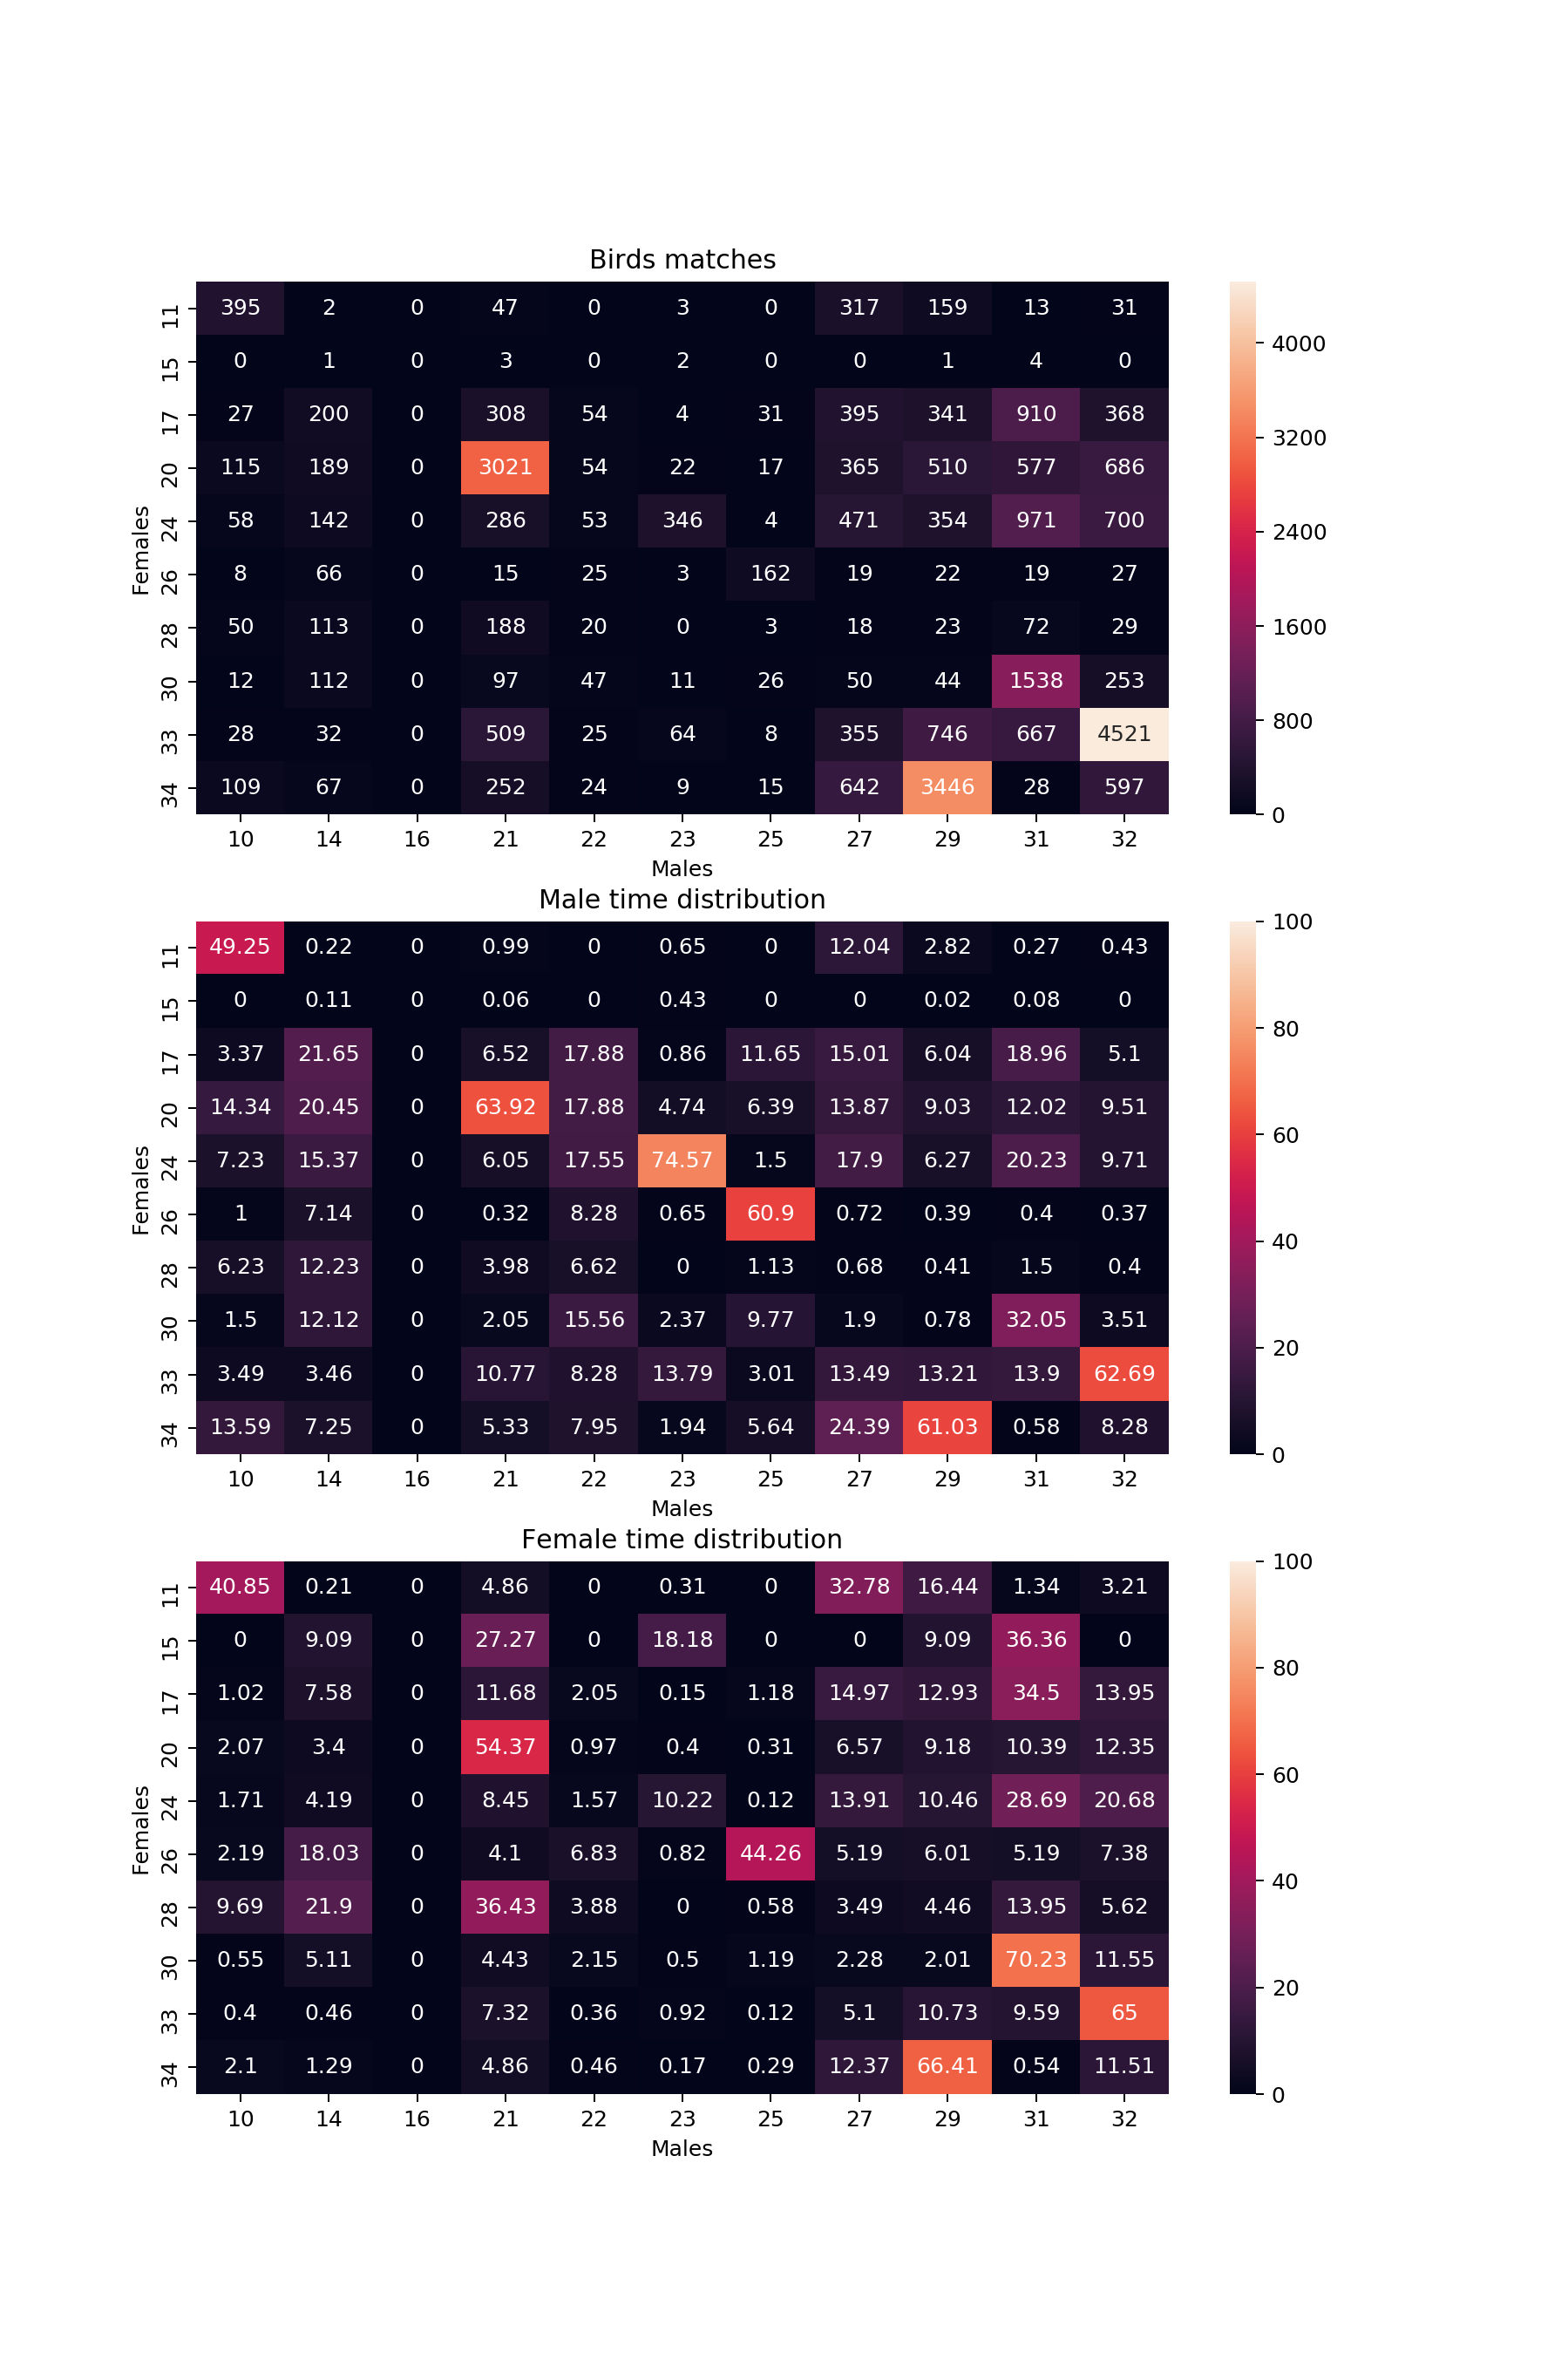

In [28]:
evaluate_near_antenna_coocurrence(predictions)

<IPython.core.display.Javascript object>


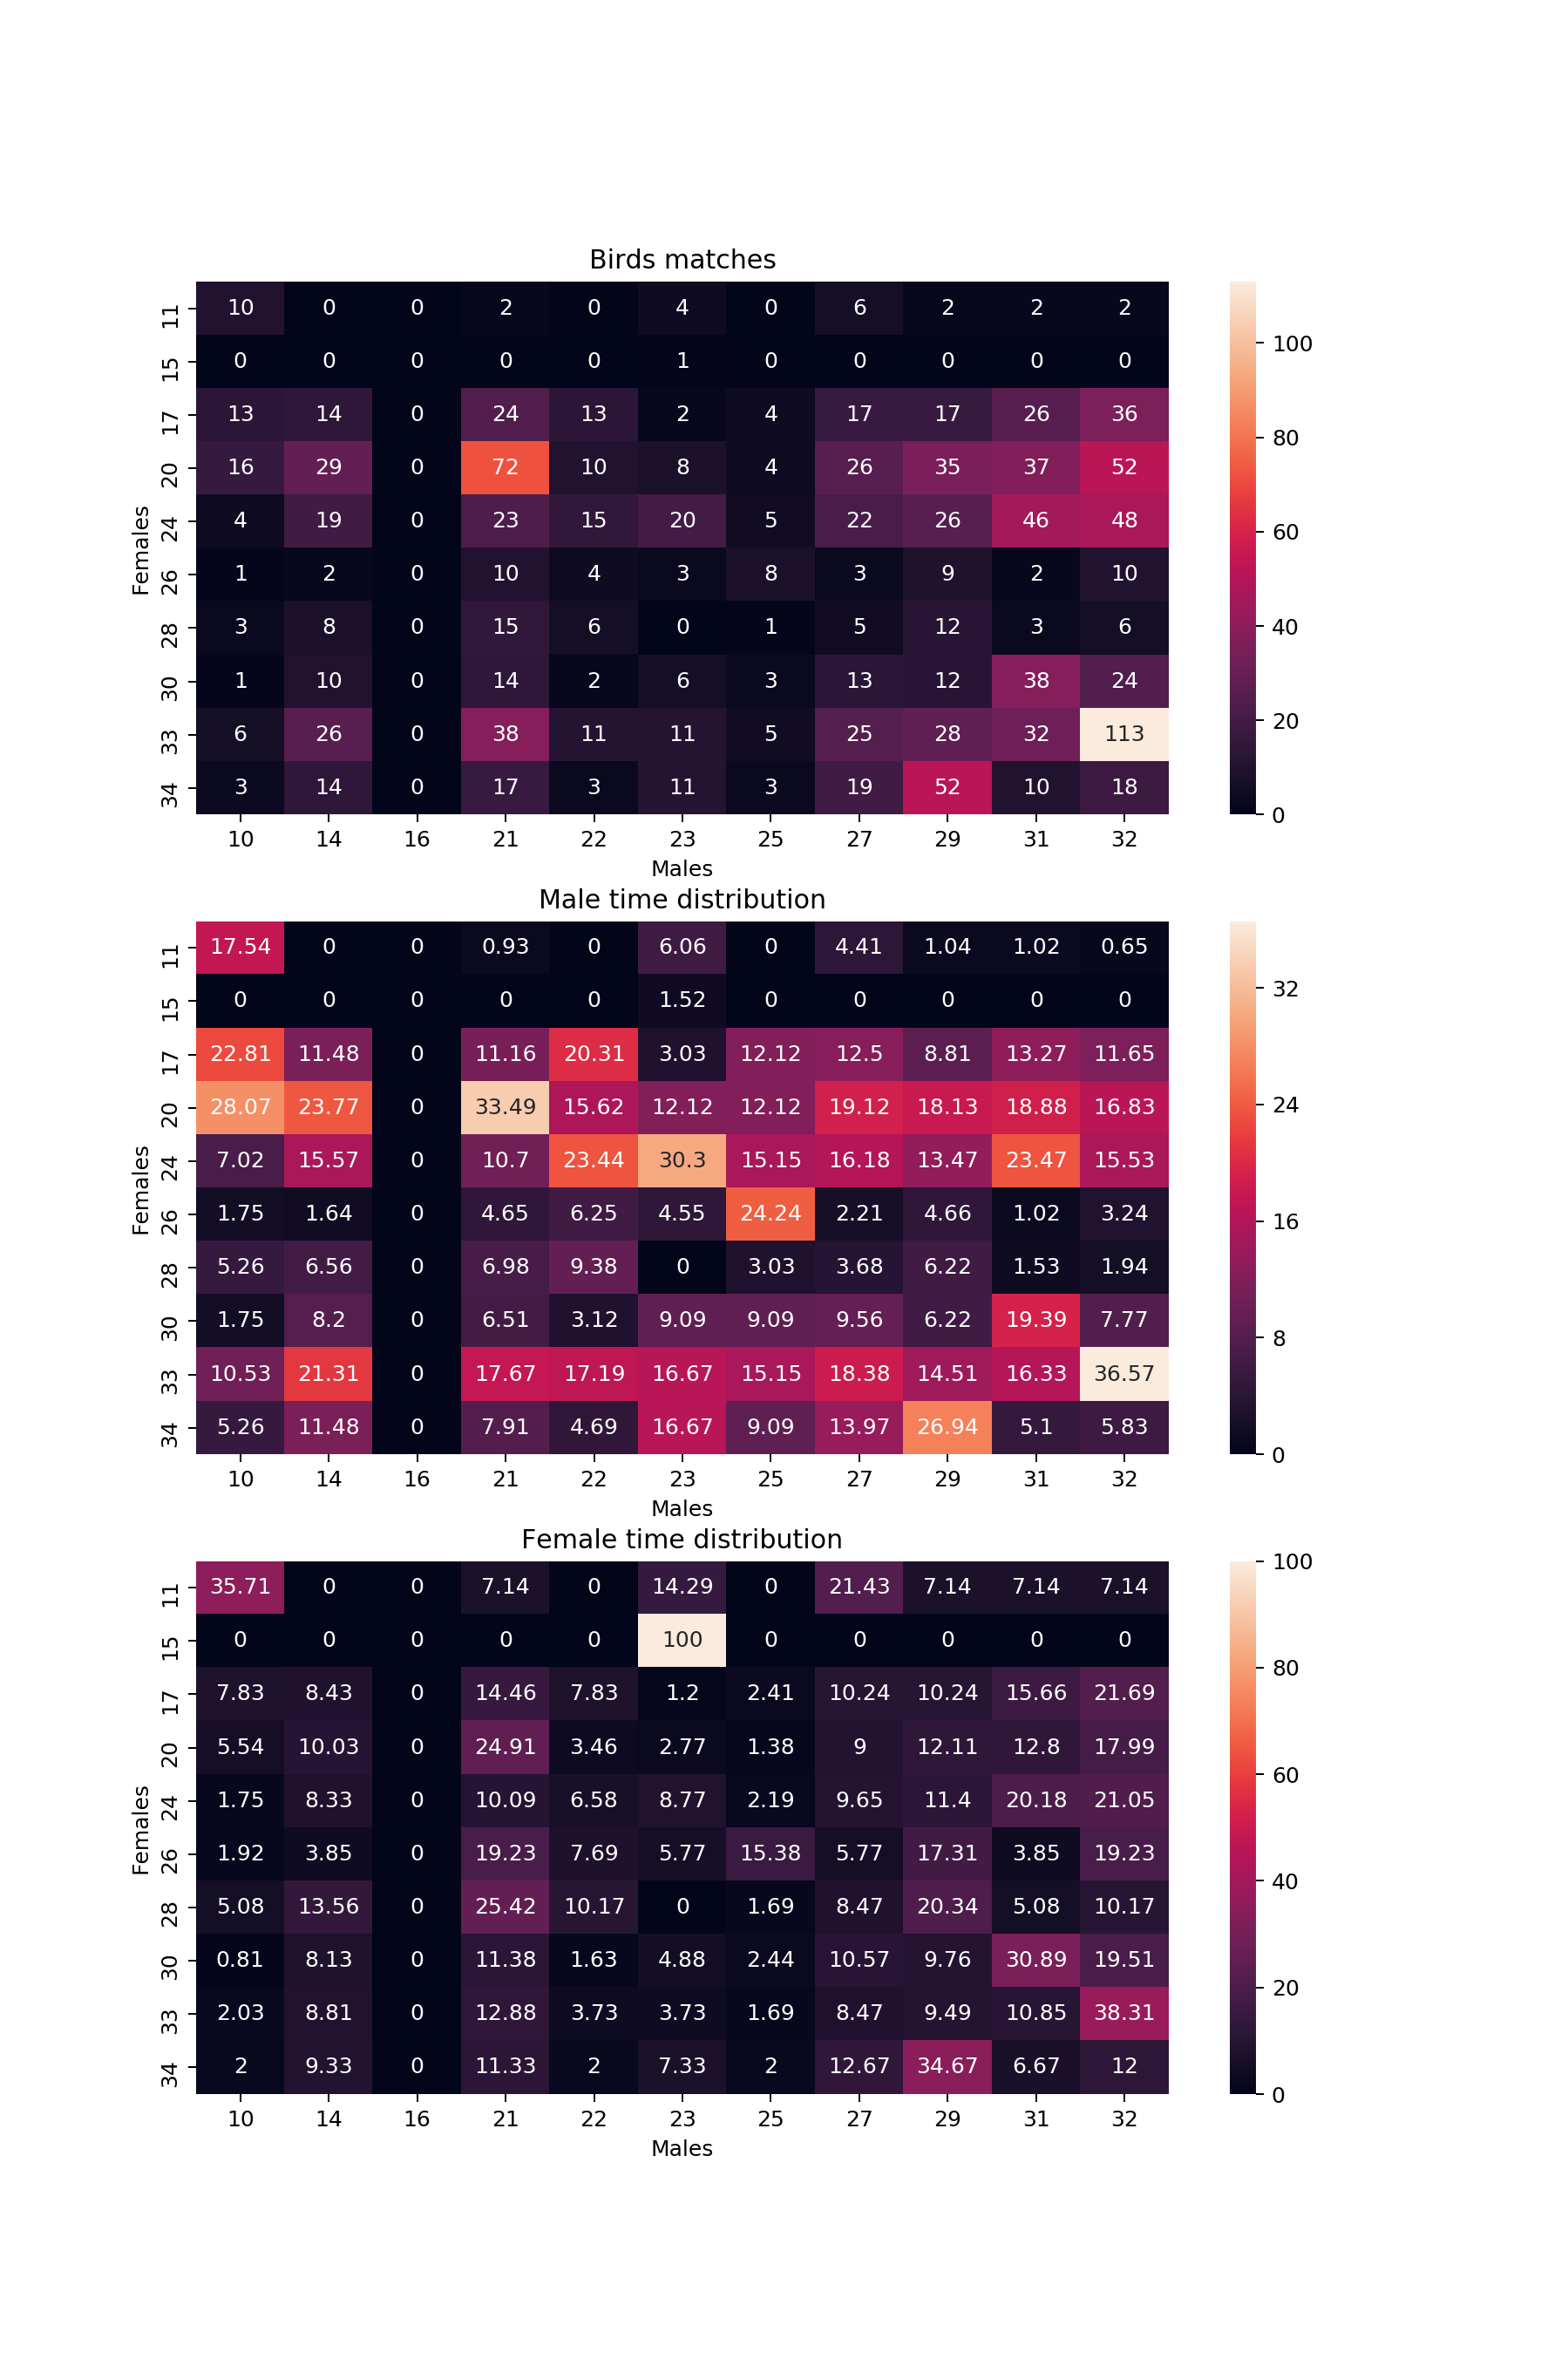

In [64]:
evaluate_near_antenna_coocurrence(random_predictions)

<IPython.core.display.Javascript object>


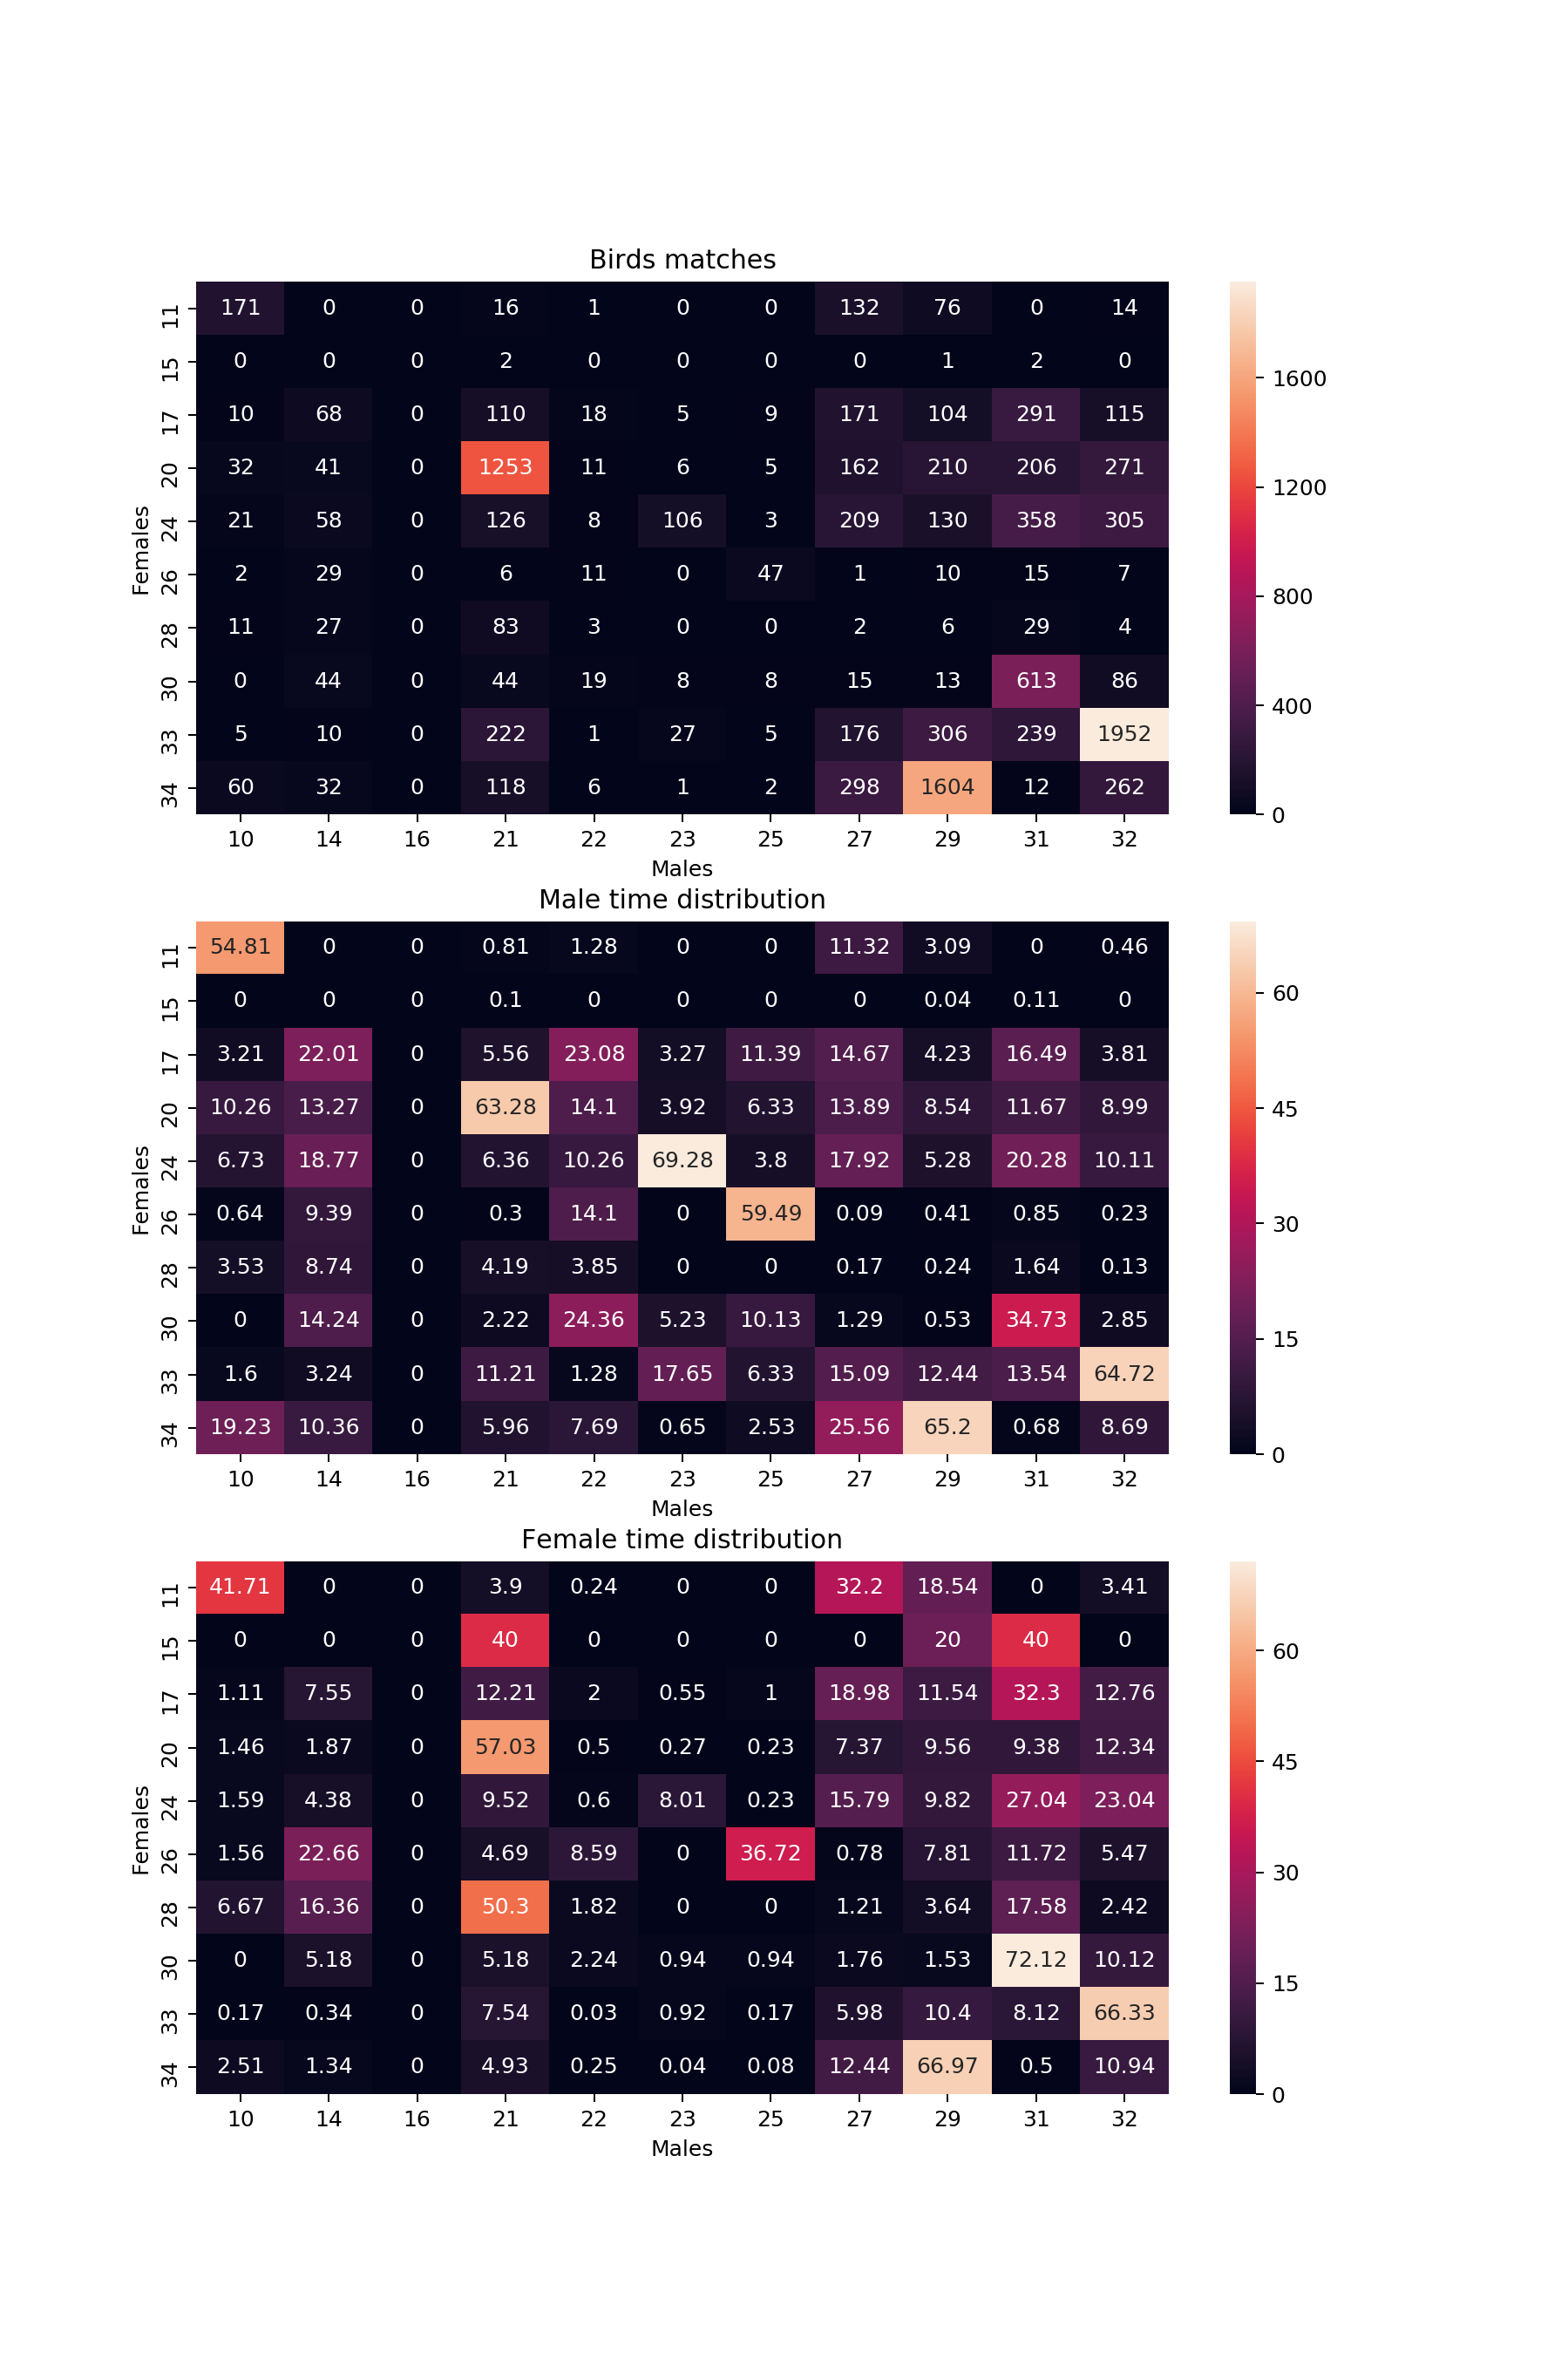

In [65]:
evaluate_near_antenna_coocurrence(smooth_predictions, 5+smoother.step_size)

## Analizo coocurrencia en regiones uniformes

### Calculo en que region cayo la prediccion

In [21]:
X_REGION_SIZE = 300
Y_REGION_SIZE = 300

def set_prediction_in_regions_classification(predictions):
    grid_predictions = []
    for i in range(len(predictions)):
        prediction = predictions[i]
        point = Point(prediction[0], prediction[1])

        region = '{}-{}'.format(int(prediction[0]/X_REGION_SIZE), int(prediction[1]/Y_REGION_SIZE))

        grid_pred = np.insert(prediction, 8,region, axis=0)
        grid_predictions.append(grid_pred)
    return pd.DataFrame(grid_predictions, columns=['x', 'y', 'recep_0', 'recep_1', 'recep_2', 'recep_3', 'tag', 'time', 'region'])


### Obtengo el tiempo que cada posible pareja estuvo junta

In [22]:
def get_bird_timestamp_in_regions(bird_data, delta_time_in_sec):
    """
    delta_time_in_sec es la cantidad de segundos que decimos que el pajaro se encuentra en un mismo punto dada una prediccion
    Por default, el valor es 5, ya que las emisiones son cada 5 segundos.
    """
    timestamp_in_grid = []
    for row in zip(bird_data.time, bird_data.region):
        real_time = datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S')
        for i in range(-delta_time_in_sec, delta_time_in_sec+1):
            res=real_time+timedelta(seconds=i)
            timestamp_in_grid.append((row[1], datetime.strftime(res, '%Y-%m-%d %H:%M:%S')))

    timestamp_in_grid = list(set(timestamp_in_grid))
    return pd.DataFrame(timestamp_in_grid, columns=['region','time'])


def get_matches_per_bird_in_regions(grid_predictions, delta_time):
    male_birds_in_grid = grid_predictions[(grid_predictions.tag.isin(MALES)) & (grid_predictions.region.notnull())]

    matches_per_bird_near_antenna = {}
    for female_bird in FEMALES:
        female_bird_in_grid = grid_predictions[(grid_predictions['tag'] == female_bird) & (grid_predictions.region.notnull())]
        timestamp_in_grid_pd = get_bird_timestamp_in_regions(female_bird_in_grid, delta_time)

        male_in_grid_with_female = male_birds_in_grid.join(timestamp_in_grid_pd.set_index(['region','time']), on=['region','time'], how='inner')

        female_matches = {}
        for index, row in male_in_grid_with_female.iterrows():
            tag = row['tag']
            current_matches = female_matches.get(tag, 0)
            female_matches[tag] = current_matches+1

        matches_per_bird_near_antenna[female_bird] = female_matches
    return matches_per_bird_near_antenna



In [23]:
def evaluate_in_regions_coocurrence(predictions, delta_time=5):
    predictions = set_prediction_in_regions_classification(predictions)
    matches_per_bird = get_matches_per_bird_in_regions(predictions, delta_time)
    show_confusion_matrices(matches_per_bird)

<IPython.core.display.Javascript object>


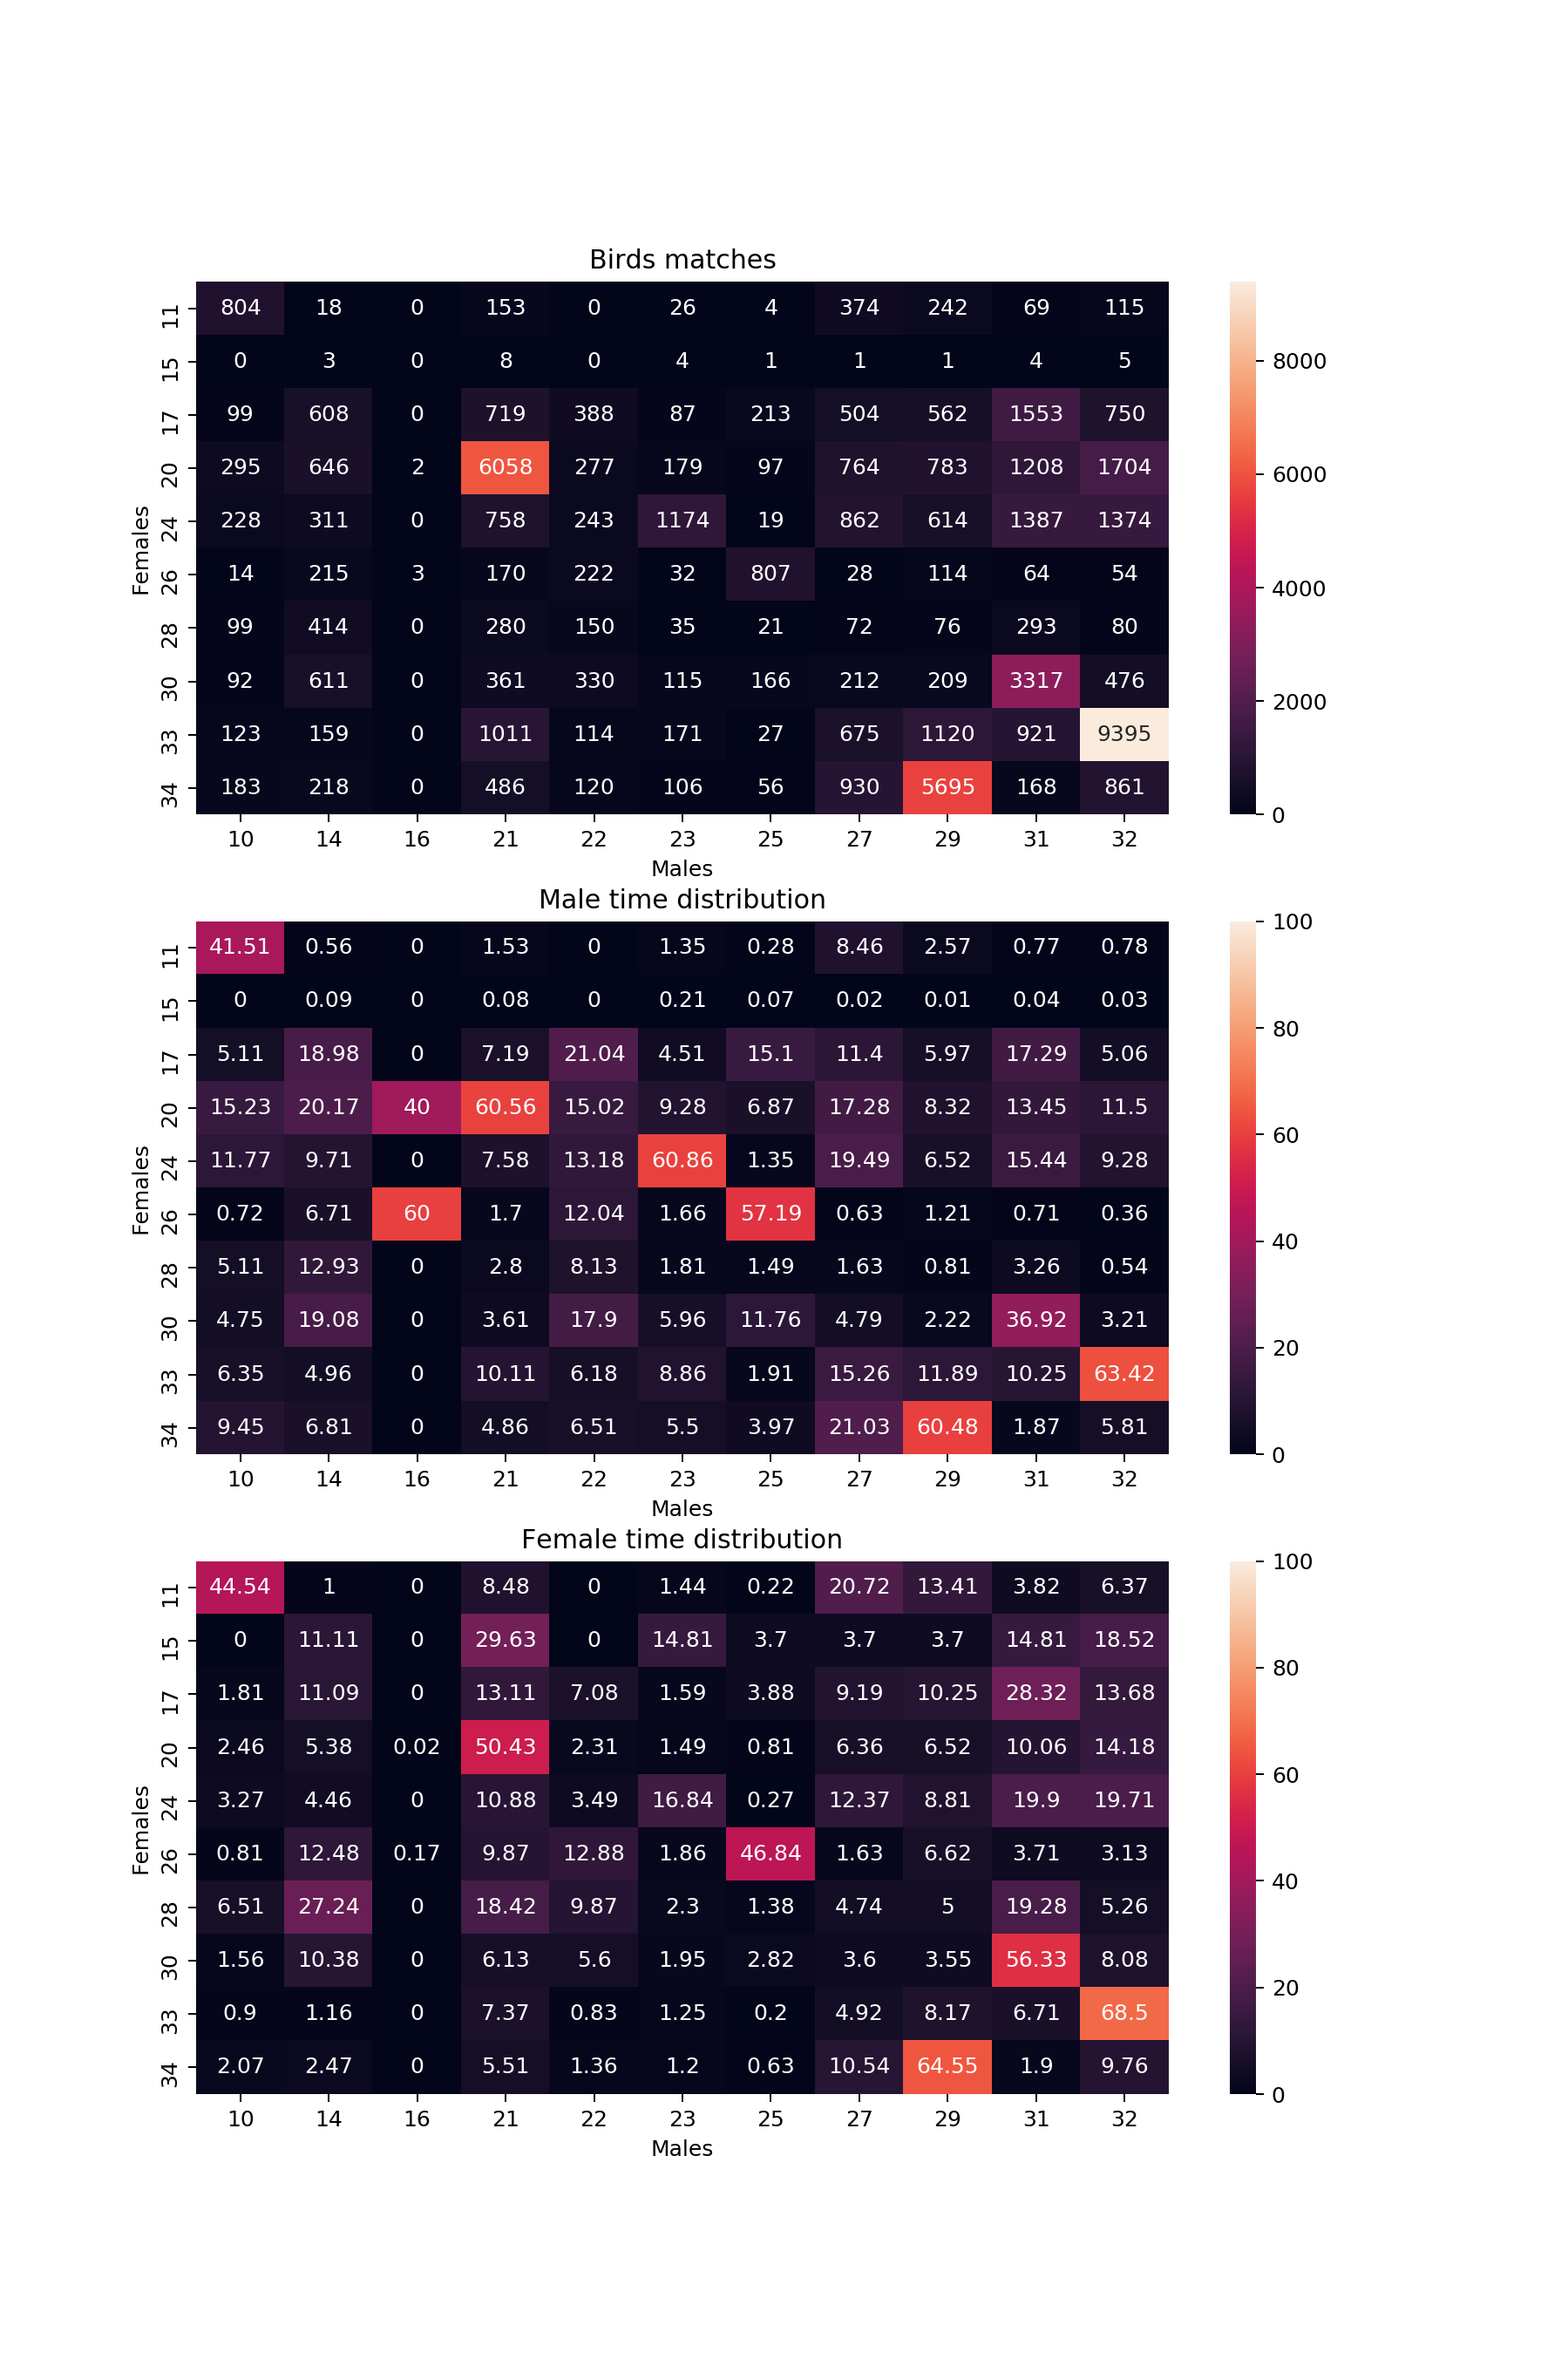

In [26]:
evaluate_in_regions_coocurrence(predictions)

<IPython.core.display.Javascript object>


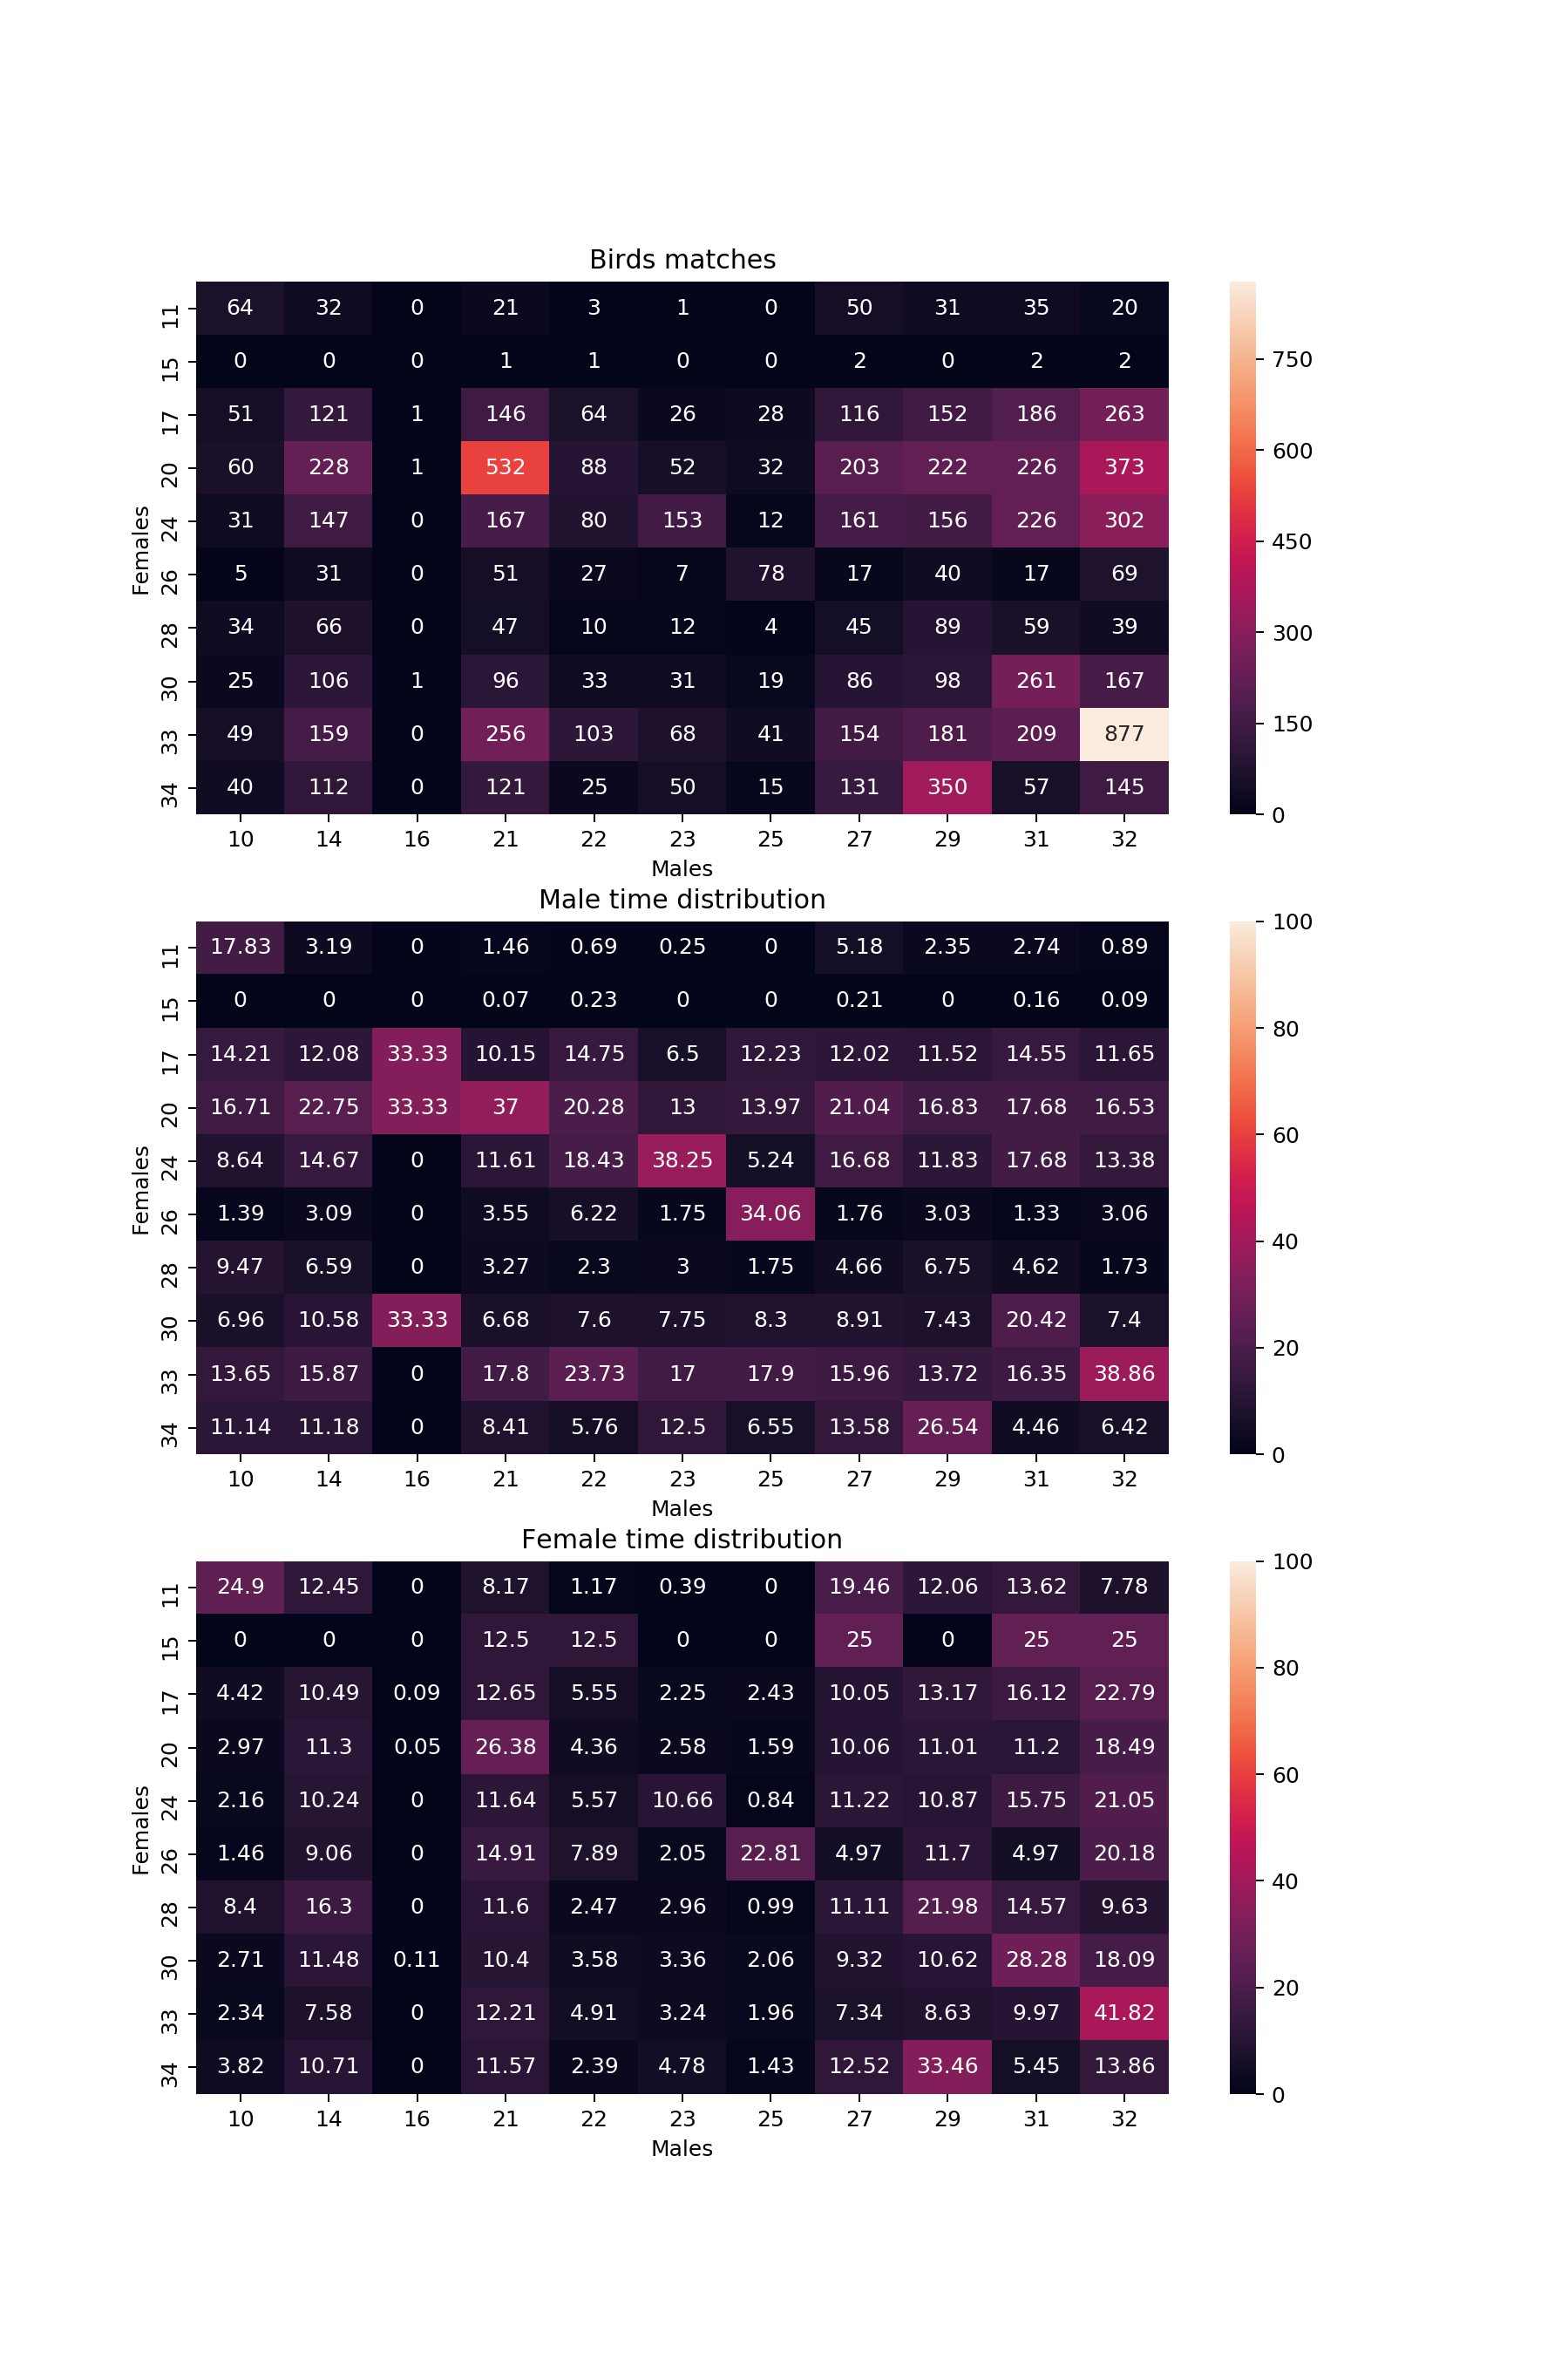

In [27]:
evaluate_in_regions_coocurrence(random_predictions)

<IPython.core.display.Javascript object>


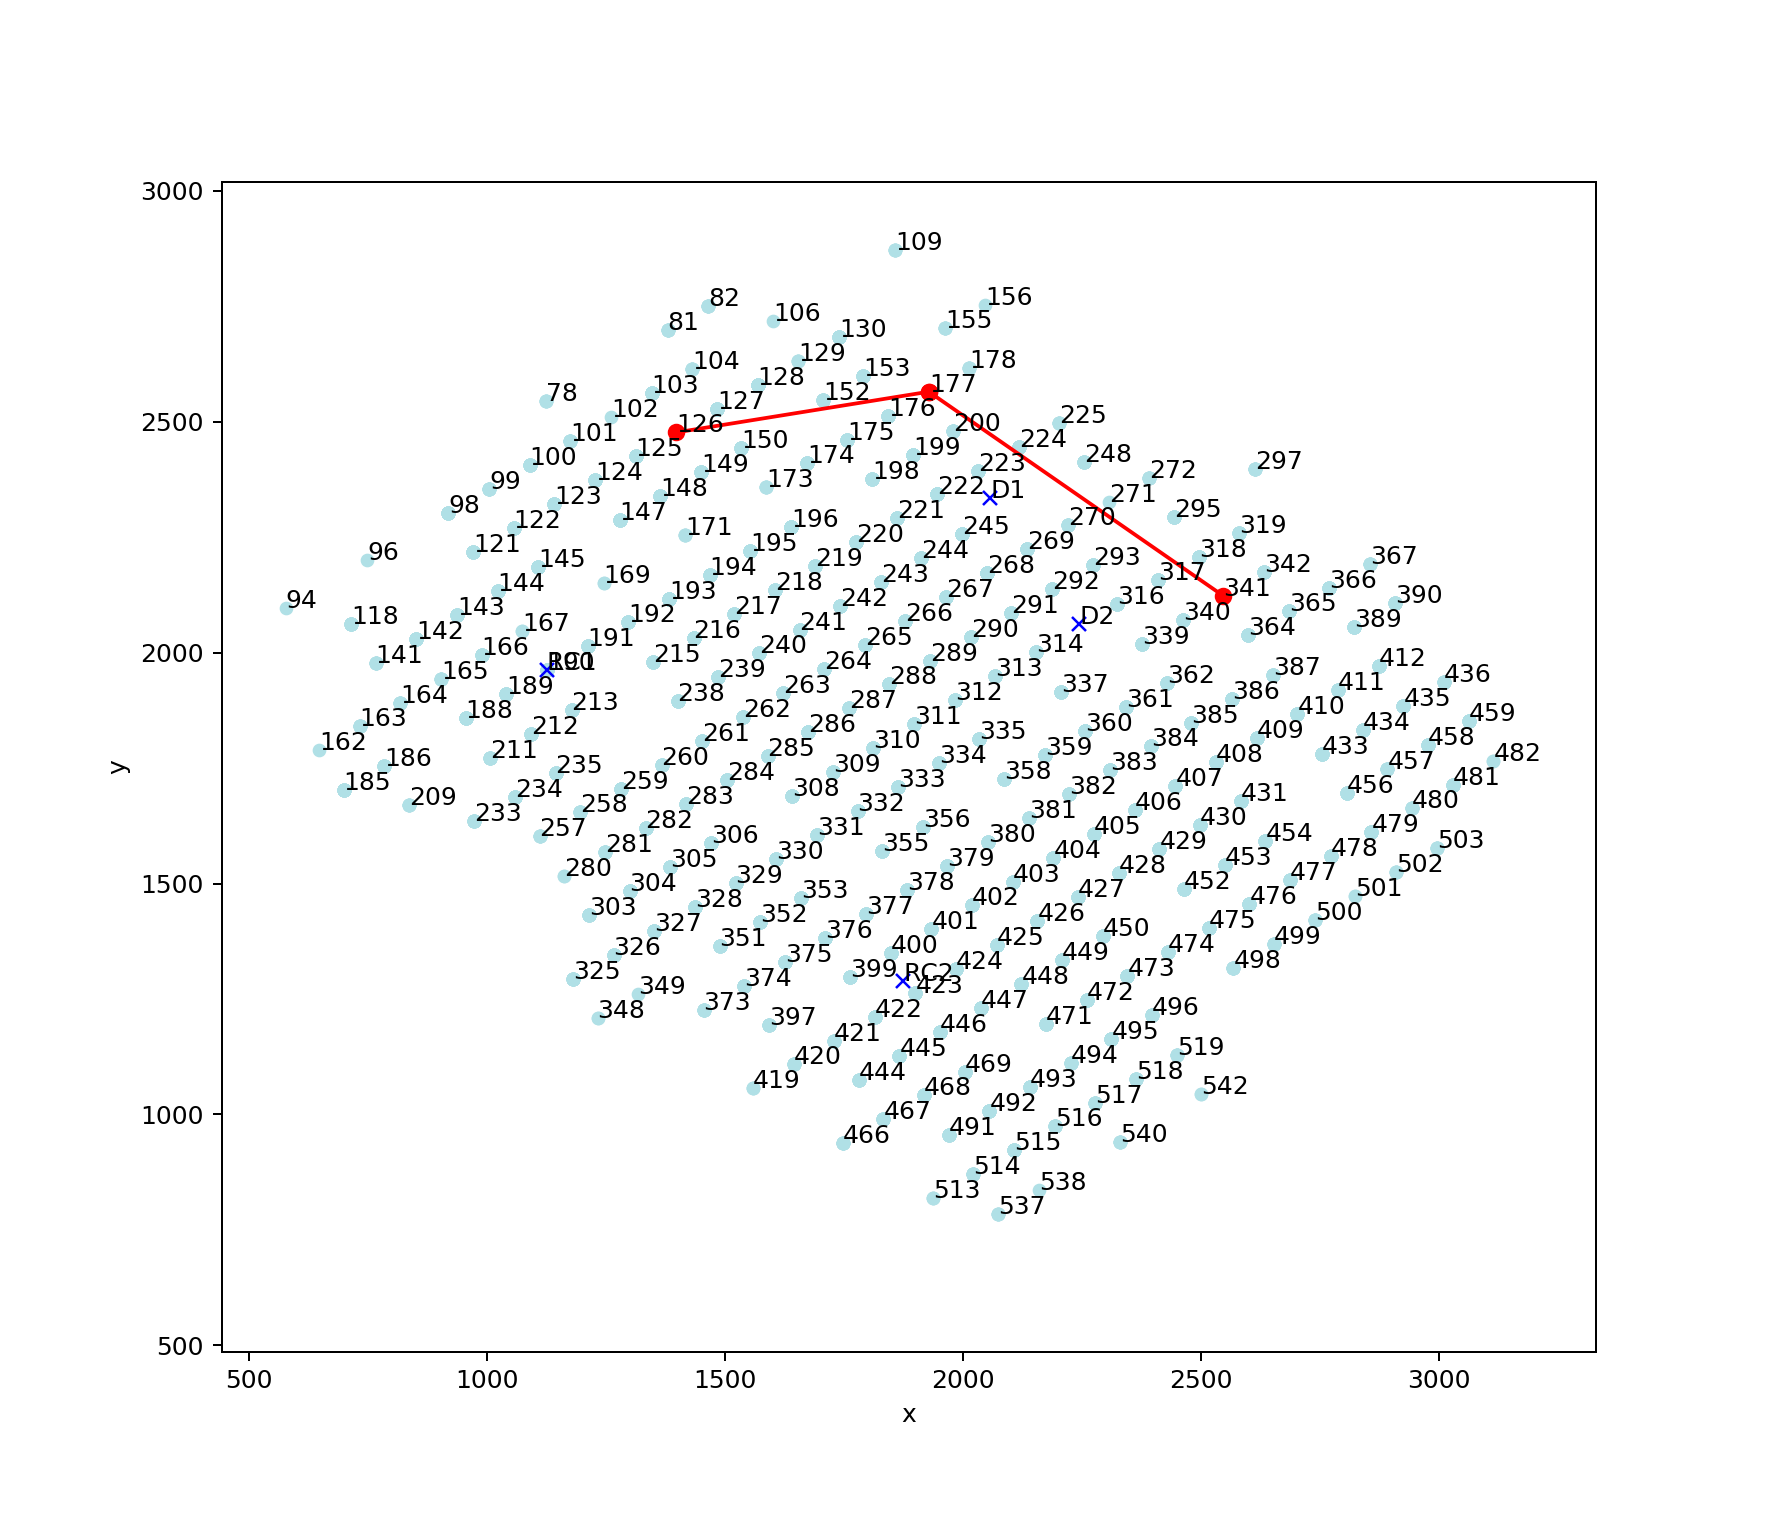

(0, 3572.611122813949)

In [37]:
x_f = 465958.114906211
y_f = 6112715.80637111
posicion_antenas = [(463512.015195402,6111004.324434620),(464259.981343845,6110331.85100085),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
nombre_antenas = ["RC1", "RC2", "D1", "D2"] 

#points_sig = points_recep.groupBy(lambda x:x['Punto']).map(calculate_amount_antennas_recep).map(normalize_positions)
ax = pd.DataFrame(data.map(lambda x: {'x': x['x'], 'y':x['y']}).collect()).plot.scatter(x='x', y='y', c='#B0E0E6')

for i in range(4):
    pos_antena = posicion_antenas[i]
    ax.plot(pos_antena[0]-X_0, pos_antena[1]-Y_0, "xb")
    ax.text(pos_antena[0]-X_0, pos_antena[1]-Y_0, nombre_antenas[i])

'''
x,y = GRID.exterior.xy
ax.plot(x, y, color='orange', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
'''
for point in data.groupBy(lambda x: x['point']).map(lambda x: list(x[1])[0]).collect():
    ax.text(point['x'], point['y'], point['point'])

plt.plot((1928.32066337199656, 2546.9634408499696), (2565.1405697204173, 2122.9506730306894), 'ro-')
plt.plot((1928.32066337199656, 1397.9205800319905), (2565.1405697204173, 2476.9784118300304), 'ro-')
    

plt.ylim(0,y_f-Y_0)
plt.xlim(0,x_f-X_0)